# Project Lodon

- 210503064 - Muhammet Hasan Çaylı
- 200503024 - Yiğit Balcıoğlu
- 200503050 - Mehmet Emre Sezer
- 200503036 - Ali Cemal Deniz
- 210503026 - Metehan Korkmaz
- 200503035 - Ahmet Oğuz Örsler

# Web Scraping of Property Listings from Rightmove

This code block scrapes property listings from Rightmove, a real estate website, to collect detailed information about properties for sale. The script uses Selenium for browsing and BeautifulSoup for parsing the HTML content.

### Process

1. **Setup and Initialization**:
   - **Why**: The `webdriver.Chrome()` function is used to initialize a Selenium WebDriver, which automates the browser interaction for scraping. The properties list is initialized to store the scraped data.
   - The price range is specified between £800,000 and £12,000,000, and the index starts from 0 to fetch the first page of property listings.

2. **Navigating Through Pages**:
   - **Why**: A `while True` loop is used to navigate through multiple pages of property listings. The loop continues until no more listings are available.
   - The URL is dynamically updated by changing the `index` to fetch the next set of listings.

3. **Waiting for Elements to Load**:
   - **Why**: The `WebDriverWait` function ensures that the page is fully loaded before scraping the data. This prevents the script from trying to access elements that aren't yet present on the page.
   - It waits for the presence of property cards (`propertyCard` class) to confirm that the listings are visible.

4. **Scraping Property Data**:
   - **Why**: Each property card is parsed using BeautifulSoup to extract essential information like price, address, and property link.
   - After obtaining the property link, the script navigates to the individual property page to fetch additional details such as property type, number of bedrooms, bathrooms, and size.

5. **Extracting Detailed Property Information**:
   - **Why**: For each property, we navigate to the detailed page to gather additional information like:
     - Property Type
     - Bedrooms
     - Bathrooms
     - Size
   - The `info-reel` section is parsed to find these details, and regex is used to extract numeric values for bedrooms and bathrooms.

6. **Avoiding Duplicates**:
   - **Why**: Before adding a new property to the list, the script checks if the property already exists in the `properties` list. This prevents duplicate entries.

7. **Pagination Handling**:
   - **Why**: The script checks for the "Next" button to determine if there are more pages to scrape. If the button is not found or is disabled, the loop breaks, and the scraping process is completed.
   - The index is updated to load the next page of listings.

8. **Saving Data to CSV**:
   - **Why**: After collecting all the listings, the data is saved into a CSV file (`9.csv`). This makes it easy to export the data for further analysis or use.
   - The `csv.writer` is used to write the headers and the scraped property data into the CSV file.

### Purpose
This step scrapes property listings from Rightmove and extracts key property details, saving them to a CSV file for further analysis. The script automates the browsing and data extraction process, making it easier to collect large amounts of property data efficiently.


In [373]:
"""from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import csv
import time
import re

def scrape_rightmove():
    driver = webdriver.Chrome()  # Chrome driver yolunu belirtin
    properties = []

    # Fiyat aralığı
    min_price = 800000
    max_price = 12000000 

    index = 0
    while True:
        driver.get(f"https://www.rightmove.co.uk/property-for-sale/find.html?locationIdentifier=REGION%5E87490&minPrice={min_price}&maxPrice={max_price}&index={index}")

        try:
            # Sayfanın tam olarak yüklenmesini beklemek gerekebilir
            WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, 'propertyCard')))
        except:
            # Eğer sayfa yüklenmezse veya daha fazla veri yoksa döngüyü sonlandır
            break

        soup = BeautifulSoup(driver.page_source, 'html.parser')
        listings = soup.find_all('div', class_='propertyCard')

        if not listings:
            # Eğer listede daha fazla emlak yoksa döngüyü sonlandır
            break

        for listing in listings:
            try:
                # Temel Bilgiler
                price = listing.find('div', class_='propertyCard-priceValue').text.strip() if listing.find('div', class_='propertyCard-priceValue') else 'N/A'
                address = listing.find('address', class_='propertyCard-address').text.strip() if listing.find('address', class_='propertyCard-address') else 'N/A'

                link = listing.find('a', class_='propertyCard-link')
                if link:
                    property_url = "https://www.rightmove.co.uk" + link['href']

                    # Ilana tıklayarak detaylı bilgi almak
                    driver.get(property_url)
                    try:
                        WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.ID, 'info-reel')))
                    except:
                        continue

                    property_soup = BeautifulSoup(driver.page_source, 'html.parser')

                    # PROPERTY TYPE, BEDROOMS, BATHROOMS, SIZE bilgilerini al
                    property_type = 'N/A'
                    bedrooms = 'N/A'
                    bathrooms = 'N/A'
                    size = 'N/A'

                    info_reel = property_soup.find('dl', {'id': 'info-reel'})
                    if info_reel:
                        info_items = info_reel.find_all('div', class_='_3gIoc-NFXILAOZEaEjJi1n')
                        for item in info_items:
                            label = item.find('span', class_='ZBWaPR-rIda6ikyKpB_E2')
                            value = item.find('p', class_='_1hV1kqpVceE9m-QrX_hWDN')
                            if label and value:
                                label_text = label.text.strip().lower()
                                if 'bedroom' in label_text:
                                    bedrooms = re.search(r'\d+', value.text.strip()).group() if re.search(r'\d+', value.text.strip()) else 'N/A'
                                elif 'bathroom' in label_text:
                                    bathrooms = re.search(r'\d+', value.text.strip()).group() if re.search(r'\d+', value.text.strip()) else 'N/A'
                                elif 'size' in label_text or 'sq ft' in label_text:
                                    size = value.text.strip()
                                elif 'property type' in label_text:
                                    property_type = value.text.strip()

                    # Eğer bu property zaten listede varsa eklemeyi atla
                    if [address, price, property_type, bedrooms, bathrooms, size] not in properties:
                        properties.append([address, price, property_type, bedrooms, bathrooms, size])
            except AttributeError:
                continue

        # "Next" butonunu kontrol et
        next_button = soup.find('button', {'data-test': 'pagination-next'})
        if not next_button or 'disabled' in next_button.get('class', []):
            break

        # Bir sonraki sayfa için index güncelle
        index += 24

    driver.quit()

    # CSV'ye Kaydet
    with open('9.csv', 'w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(['Address', 'Price', 'Property Type', 'Bedrooms', 'Bathrooms', 'Size'])
        writer.writerows(properties)

scrape_rightmove()"""

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
/var/folders/y3/9sgnt_554y34mk2m7wqzp4nh0000gn/T/ipykernel_75050/189859070.py:1: SyntaxWarning: invalid escape sequence '\d'
  """from selenium import webdriver


'from selenium import webdriver\nfrom selenium.webdriver.common.by import By\nfrom selenium.webdriver.support.ui import WebDriverWait\nfrom selenium.webdriver.support import expected_conditions as EC\nfrom bs4 import BeautifulSoup\nimport csv\nimport time\nimport re\n\ndef scrape_rightmove():\n    driver = webdriver.Chrome()  # Chrome driver yolunu belirtin\n    properties = []\n\n    # Fiyat aralığı\n    min_price = 800000\n    max_price = 12000000 \n\n    index = 0\n    while True:\n        driver.get(f"https://www.rightmove.co.uk/property-for-sale/find.html?locationIdentifier=REGION%5E87490&minPrice={min_price}&maxPrice={max_price}&index={index}")\n\n        try:\n            # Sayfanın tam olarak yüklenmesini beklemek gerekebilir\n            WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, \'propertyCard\')))\n        except:\n            # Eğer sayfa yüklenmezse veya daha fazla veri yoksa döngüyü sonlandır\n            break\n\n        soup = Beautif

## Why We Fetched the Data in Small Intervals Instead of All at Once?

The Rightmove site shows a total of `43 pages`, with `25 listings` per page. So, a total of `43 x 25 = 1075` adverts can be fetched at once. However, there are about `45k` listings on the site. To fetch all the data, we identified intervals with 1075 adverts and scraped the data accordingly. To speed up the process, we divided the data `into 6 parts`. Each person saved their part as `1.csv, 2.csv, ..., 9.csv`, and then merged them into a file called `group1.csv`. We then combined the data from all group members (`group1 to group6`).

# Library Import and Data Merging

This code block loads the necessary libraries and performs data merging for the project.

### Libraries Used
- **pandas**: For data manipulation and analysis.
- **numpy**: For numerical operations.
- **matplotlib** and **seaborn**: For data visualization.
- **sklearn**: For data preprocessing and model training.

### Process
1. **Loading Libraries**: All essential libraries and tools required for the project are imported.
2. **Loading and Merging Data**:
   - CSV file names are listed as `grup1.csv` to `grup6.csv`.
   - All CSV files are loaded using `pandas.read_csv()` and merged using `pd.concat()`.
3. **Checking the Combined DataFrame**:
   - The first few rows of the combined data frame are displayed using `combined_df.head()` to ensure correctness.
4. **Saving the DataFrame**:
   - The combined data is saved into a single CSV file named `data.csv`.

This step establishes the foundation for data preparation in the project. The merged data will be used in subsequent steps for cleaning and analysis.


In [374]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load the data

# CSV dosyalarının isimlerini listele
csv_files = [f"grup{i}.csv" for i in range(1, 7)]

# CSV dosyalarını yükle ve birleştir
dfs = [pd.read_csv(file) for file in csv_files]
combined_df = pd.concat(dfs, ignore_index=True)

# Birleştirilmiş DataFrame'i kontrol et
print(combined_df.head())

combined_df.to_csv("data.csv", index=False)

                           Address     Price Property Type  Bedrooms  \
0      Eloise House, Portland Road  £330,000     Apartment       1.0   
1      Wimbledon Park Side, Putney  £340,000          Flat       1.0   
2  Rolfe Terrace, Woolwich, London  £340,000     Apartment       1.0   
3           Rectory Square, LONDON  £340,000          Flat       1.0   
4      Kingston Road, London, SW20  £340,000          Flat       1.0   

   Bathrooms       Size  
0        1.0  518 sq ft  
1        1.0  Ask agent  
2        1.0  Ask agent  
3        1.0  Ask agent  
4        1.0  388 sq ft  


In [375]:
df = pd.read_csv("data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40728 entries, 0 to 40727
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Address        40728 non-null  object 
 1   Price          40728 non-null  object 
 2   Property Type  40555 non-null  object 
 3   Bedrooms       39252 non-null  float64
 4   Bathrooms      39315 non-null  float64
 5   Size           40728 non-null  object 
dtypes: float64(2), object(4)
memory usage: 1.9+ MB


### Process
1. **Address Column (object type)**:
   - **Data Issues**:
       - The Address column contains string values, which typically represent addresses. Addresses are not directly useful for modeling but might contain valuable information, such as cities or regions.
2. **Price Column (object type)**:
      - **Data Issues**:
           - The Price column is represented as a string (object), which may contain non-numeric characters (e.g., currency symbols or commas).
3. **Property Type Column (object type)**:
      - **Data Issues**:
           - The Property Type column contains categorical data with a small number of missing values.
4. **Bedrooms Column (float64 type)**:
      - **Data Issues**:
           - The Bedrooms column contains numerical data, but there are missing values.
5. **Bathrooms Column (float64 type)**:
      - **Data Issues**:
           - Similar to the Bedrooms column, the Bathrooms column contains numerical data with missing values.
6. **Size Column (object type)**:
      - **Data Issues**:
           - The Size column contains numeric values represented as strings (e.g.,"100 sq ft"), which need to be converted to a numeric format.

# Data Quality Check: Missing Values and Duplicates

This code block performs a basic data quality check by identifying missing values and duplicated rows in the dataset.

### Process

1. **Loading the Dataset**:
   - The dataset is loaded from `data.csv` into a pandas DataFrame (`df`).

2. **Checking Missing Values**:
   - The `isnull().sum()` method calculates the number of missing (`NaN`) values for each column.
   - Results are printed with the column-wise count of missing values.

3. **Calculating Missing Value Percentage**:
   - The percentage of missing values in each column is calculated using:
     ```python
     (df.isnull().sum() / len(df)) * 100
     ```
   - This provides a relative measure of data completeness for each column, expressed as a percentage.

4. **Identifying Duplicated Rows**:
   - The `duplicated().sum()` method counts the number of duplicated rows in the dataset.
   - A subset of all duplicated rows is extracted using `df.duplicated(keep=False)`, displaying them for inspection.

5. **Printing Results**:
   - Displays:
     - Missing value counts and percentages per column.
     - Total number of duplicated rows.
     - Detailed view of duplicated rows for further investigation.

### Purpose
This step evaluates the quality of the dataset by identifying missing values and duplicates, enabling informed decisions about data cleaning, imputation, or removal. It ensures the dataset is consistent and reliable for subsequent analysis or modeling.


In [376]:
import pandas as pd

# Örnek: 'data.csv' adlı dosyadan veri oku
df = pd.read_csv("data.csv")

missing_counts = df.isnull().sum()
print("Missing (NaN) counts per column:\n", missing_counts)

missing_percentage = (df.isnull().sum() / len(df)) * 100
print("Missing percentage per column (%):\n", missing_percentage)

duplicates_count = df.duplicated().sum()
print("Number of duplicated rows:", duplicates_count)

duplicates_df = df[df.duplicated(keep=False)]
print("Duplicated rows:")
print(duplicates_df)




Missing (NaN) counts per column:
 Address             0
Price               0
Property Type     173
Bedrooms         1476
Bathrooms        1413
Size                0
dtype: int64
Missing percentage per column (%):
 Address          0.000000
Price            0.000000
Property Type    0.424769
Bedrooms         3.624042
Bathrooms        3.469358
Size             0.000000
dtype: float64
Number of duplicated rows: 781
Duplicated rows:
                                                 Address       Price  \
23                         Sherard Road, Eltham, SE9 6EX    £340,000   
30                         Sherard Road, Eltham, SE9 6EX    £340,000   
416                           Putney High Street, Putney    £345,000   
423                           Putney High Street, Putney    £345,000   
529                       St. Davids Square, London, E14    £350,000   
...                                                  ...         ...   
40079  Lexington House, 10 - 14 Auriol Road, London, W14  £1,1

# Removing Duplicate Rows from the Dataset

This code block identifies and removes duplicate rows from the dataset, ensuring data consistency and reducing redundancy.

### Process

1. **Counting Duplicate Rows**:
   - The `duplicated().sum()` method calculates the total number of duplicate rows in the dataset.
   - A message displaying the count of duplicate rows is printed.

2. **Dropping Duplicate Rows**:
   - The `drop_duplicates()` method removes duplicate rows while keeping the first occurrence of each:
     - Duplicates are identified based on all columns.
     - The resulting DataFrame (`df_cleaned`) contains only unique rows.

3. **Optional: In-Place Modification**:
   - The `inplace=True` parameter can be added to modify the original DataFrame directly, avoiding the creation of a new DataFrame.

4. **Displaying Results**:
   - Prints the shape (row and column count) of the cleaned DataFrame (`df_cleaned`) after duplicates are removed.

### Purpose
This step ensures the dataset contains only unique rows by identifying and removing duplicates. Cleaning duplicate data improves the reliability of analysis, modeling, and reporting by preventing overrepresentation of certain data points.


In [377]:
# 1) Tekrarlı satır sayısı
num_duplicates = df.duplicated().sum()
print(f"Toplam duplikate satır sayısı: {num_duplicates}")

# 2) Tekrarlı satırları düşür (ilk görülen satırı tutar, sonraki kopyaları siler)
df_cleaned = df.drop_duplicates()

# 3) İsterseniz df'yi yerinde değiştirebilirsiniz (inplace=True)
# df.drop_duplicates(inplace=True)

# 4) Sonuç
print("Duplikateler silindikten sonra DataFrame boyutu:", df_cleaned.shape)

Toplam duplikate satır sayısı: 781
Duplikateler silindikten sonra DataFrame boyutu: (39947, 6)


In [378]:
df_cleaned.to_csv("data.csv", index=False)

# Extracting Postcodes from Address Data

This code block extracts postcodes from the address column of a CSV file using regular expressions. It identifies postcode patterns in the addresses and saves the extracted postcodes in a new column.

### Process

1. **Regular Expression Pattern**:
   - **Why**: A regular expression pattern (`pattern`) is defined to capture postcodes from the address. The pattern looks for combinations of letters and digits typically found in postcodes, such as "A1", "SW1A", or "AB12".
   - The pattern uses a non-capturing group `(?:^|\s|,)` to match the start of the string, whitespace, or a comma, followed by the postcode pattern, and ensures that the postcode is followed by either the end of the string, whitespace, or a comma.

2. **Loading the Data**:
   - **Why**: The dataset (`data.csv`) is loaded into a Pandas DataFrame (`df`) for further processing. The address column is where the postcodes are extracted from.

3. **Extracting Postcodes**:
   - **Why**: The function `find_codes()` is defined to apply the regular expression to each address. It returns a list of matching postcodes for each address.
   - If postcodes are found, they are joined into a single string (separated by commas). If no matches are found, it returns `0` or an empty string.

4. **Applying the Function**:
   - **Why**: The `apply()` function is used to apply `find_codes()` to each row in the `Address` column. The extracted postcodes are stored in a new column called `Posta Kodu`.

5. **Filtering Rows**:
   - **Why**: After extracting the postcodes, rows where the postcode is `0` (no match found) are filtered out. This ensures that only addresses with valid postcodes remain in the dataset.

6. **Saving the Data**:
   - **Why**: The cleaned dataset, now containing the extracted postcodes, is saved back into the original CSV file (`data.csv`), ensuring that the modifications are saved for further use or analysis.

### Purpose
This step automates the process of extracting postcodes from the address data in the CSV file. The extracted postcodes are saved in a new column for easy access and further analysis. The script ensures that only addresses with valid postcodes are retained in the dataset.


In [379]:
import pandas as pd
import re


pattern = r'(?:^|\s|,)([A-Z]{1,2}\d{1,2}[A-Z]?)(?=$|\s|,)'
df = pd.read_csv("data.csv")
def find_codes(adress):
    # Adres metnindeki eşleşmeleri liste olarak döndürür
    matches = re.findall(pattern, str(adress), flags=re.IGNORECASE)
    if matches:
        # Örnek olarak virgülle birleştirip döndürelim
        return ", ".join(matches)
    else:
        return 0  # ya da boş string

df["Posta Kodu"] = df["Address"].apply(find_codes)
df = df[df["Posta Kodu"] != 0]
df.to_csv("data.csv", index=False)

# Data Cleaning: Price Column Transformation

This code block performs data cleaning by transforming the `Price` column in the dataset into a numeric format.

### Process
1. **Loading the Dataset**:
   - The `data.csv` file is loaded into a pandas DataFrame using `pd.read_csv()`.
2. **Price Column Cleaning**:
   - **Removing the Pound Symbol (£)**: The `str.replace()` function removes the currency symbol `£` from the `Price` column.
   - **Removing Commas**: The `str.replace()` function also removes commas (`,`) from the `Price` values to ensure proper numerical conversion.
   - **Converting to Numeric**: The `pd.to_numeric()` function converts the cleaned `Price` column into numeric format. Any invalid entries are coerced into `NaN` values.
3. **Saving the Cleaned Data**:
   - The cleaned DataFrame is saved back into the `data.csv` file using `to_csv()`.

### Purpose
This transformation ensures that the `Price` column is in a numerical format, which is necessary for statistical analysis, data visualization, and machine learning processes in subsequent steps.


In [380]:
df = pd.read_csv("data.csv")

# Fiyatları sayısal formata dönüştürme
df['Price'] = df['Price'].str.replace('£', '', regex=False)  # £ sembolünü kaldır
df['Price'] = df['Price'].str.replace(',', '', regex=False)  # Virgülleri kaldır
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

df.to_csv("data.csv", index=False)


# Data Cleaning: Size Column Transformation

This code block cleans and transforms the `Size` column in the dataset, extracting numeric values and handling non-numeric entries.

### Process
1. **Importing Necessary Libraries**:
   - The `numpy` library is imported for handling numerical operations.
2. **Loading the Dataset**:
   - The `data.csv` file is loaded into a pandas DataFrame using `pd.read_csv()`.
3. **Defining the Cleaning Function**:
   - The `clean_size()` function:
     - Removes commas from the values in the `Size` column.
     - Splits the string and extracts the first part, assuming it represents the numeric size.
     - Converts valid numeric strings to floats.
     - Assigns `NaN` to non-numeric or missing values.
4. **Applying the Cleaning Function**:
   - The `apply()` function is used to apply `clean_size()` to each value in the `Size` column.
5. **Saving the Cleaned Data**:
   - The cleaned DataFrame is saved back into the `data.csv` file using `to_csv()`.

### Purpose
This step ensures that the `Size` column contains clean, numeric data. This transformation is crucial for numerical analysis, such as calculating averages or applying machine learning models in subsequent steps.


In [381]:
#size kolonunun işlenmesi
import numpy as np
df = pd.read_csv("data.csv")

print(df["Size"])
# "Size" kolonundan sadece sayıları çek ve diğerlerini NaN yap
def clean_size(value):
    if pd.notna(value):  # Eksik olmayan değerler için işlem yap
        cleaned_value = value.replace(',', '').split()[0]  # Virgülü kaldır ve ilk kısmı al
        if cleaned_value.isdigit():  # Eğer sayıysa
            return float(cleaned_value)  # Float olarak dönüştür
    return np.nan  # Diğer durumlarda NaN ata

# Fonksiyonu 'Size' kolonuna uygula
df['Size'] = df['Size'].apply(clean_size)
print(df["Size"])
# kaydet
df.to_csv("data.csv", index=False)

0        388 sq ft
1        230 sq ft
2        Ask agent
3        Ask agent
4        Ask agent
           ...    
28556    Ask agent
28557    Ask agent
28558    556 sq ft
28559    Ask agent
28560    832 sq ft
Name: Size, Length: 28561, dtype: object
0        388.0
1        230.0
2          NaN
3          NaN
4          NaN
         ...  
28556      NaN
28557      NaN
28558    556.0
28559      NaN
28560    832.0
Name: Size, Length: 28561, dtype: float64


# Identifying Outliers in Numeric Columns Using the IQR Rule

This code block identifies outliers in numeric columns of the dataset using the Interquartile Range (IQR) rule.

### Process

1. **Selecting Numeric Columns**:
   - The `select_dtypes(include=[np.number])` method identifies all numeric columns in the dataset.
   - The column names are stored in `numeric_cols`.

2. **Calculating IQR**:
   - For each numeric column (`col`):
     - **Q1 (1st Quartile)**: Calculated using `quantile(0.25)`.
     - **Q3 (3rd Quartile)**: Calculated using `quantile(0.75)`.
     - **IQR (Interquartile Range)**: Difference between Q3 and Q1 (`IQR = Q3 - Q1`).

3. **Defining Outlier Bounds**:
   - **Lower Bound**: `Q1 - 1.5 * IQR`
   - **Upper Bound**: `Q3 + 1.5 * IQR`

4. **Identifying Outliers**:
   - Rows with values outside the bounds are considered outliers:
     - `df[(df[col] < lower_bound) | (df[col] > upper_bound)]`
   - The count of outliers for each column is calculated and printed.

5. **Optional: Viewing Outliers**:
   - Uncomment the line `print(outliers[[col]])` to display the specific outlier values for a given column.

### Purpose
This step identifies outliers in numeric columns based on the IQR rule, helping to detect data points that may require special handling (e.g., removal, transformation, or capping). By understanding outliers, the dataset can be refined for better analysis or modeling.


In [382]:
import numpy as np

# Sayısal kolonları seçelim
numeric_cols = df.select_dtypes(include=[np.number]).columns

for col in numeric_cols:
    # 1. ve 3. çeyrek değerlerini hesapla
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    # Alt ve üst sınırlar (1.5 * IQR kuralı)
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Aykırı değerleri seç
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    
    print(f"{col} sütunu için aykırı değer sayısı: {len(outliers)}")

    # Eğer bu aykırı değerleri tek tek görmek isterseniz:
    # print(outliers[[col]])


Price sütunu için aykırı değer sayısı: 3338
Bedrooms sütunu için aykırı değer sayısı: 279
Bathrooms sütunu için aykırı değer sayısı: 1253
Size sütunu için aykırı değer sayısı: 1701


# Visualizing Outliers and Distributions in Numeric Columns

This code block visualizes the distributions of numeric columns in the dataset and highlights potential outliers using boxplots and histograms.

### Process

1. **Selecting Numeric Columns**:
   - The `select_dtypes(include=[np.number])` method identifies all numeric columns in the dataset.
   - The column names are stored in `numeric_cols`.

2. **Iterating Through Columns**:
   - For each numeric column (`col`), two types of plots are generated:
   
3. **Boxplot**:
   - A boxplot is created using `sns.boxplot()`:
     - Displays the distribution of the column and highlights outliers based on the IQR rule.
     - The box represents the interquartile range (IQR), while whiskers extend to the 1.5 * IQR range.
     - Data points outside the whiskers are considered outliers.
   - The plot is titled using `plt.title()` to specify the column name.

4. **Histogram with KDE**:
   - A histogram with a kernel density estimate (KDE) is created using `sns.histplot()`:
     - Shows the frequency distribution of values in the column.
     - KDE provides a smooth estimate of the probability density function.
     - The histogram is colored blue for visual clarity.
   - The plot is titled to match the column name.

5. **Displaying Plots**:
   - Each plot is displayed using `plt.show()`.

### Purpose
This step provides visual insights into the distribution and potential outliers in numeric columns. By combining boxplots and histograms, this approach helps identify anomalies and understand the overall data structure for better decision-making in data cleaning and preprocessing.


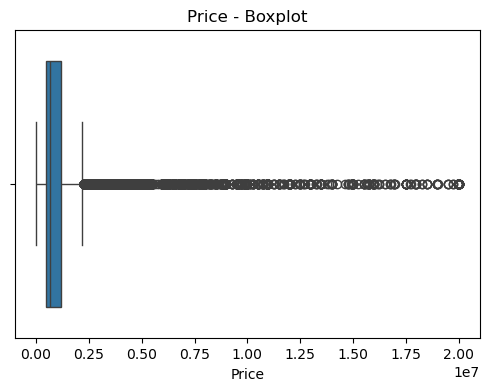

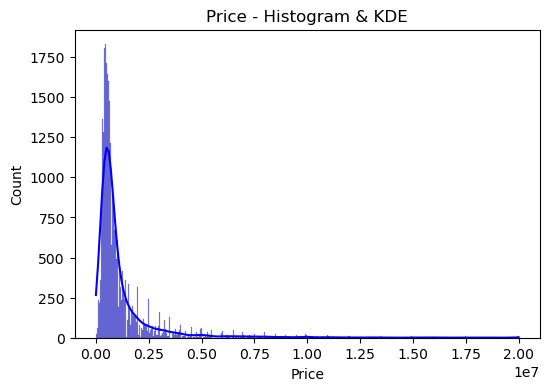

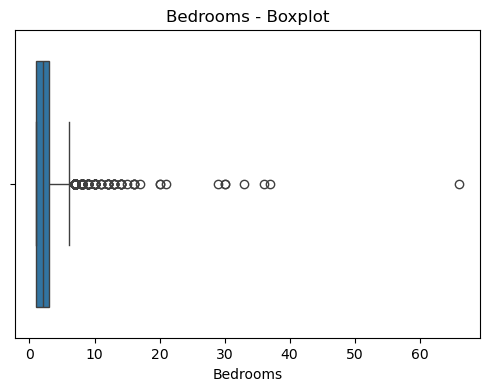

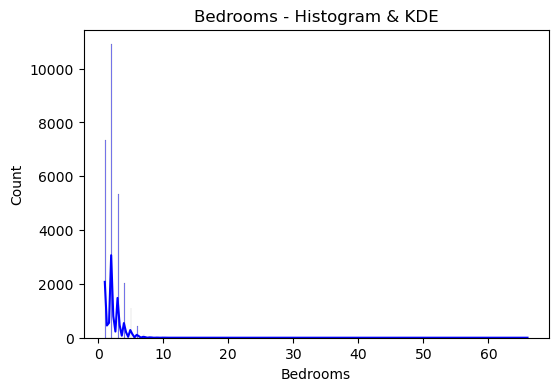

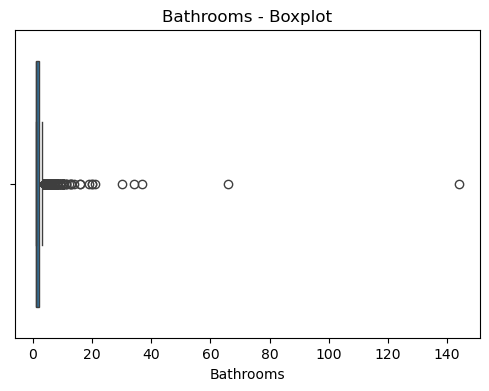

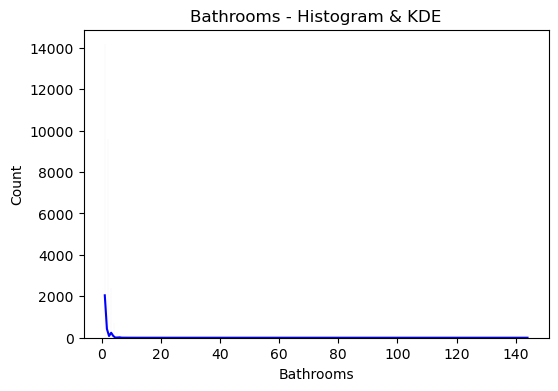

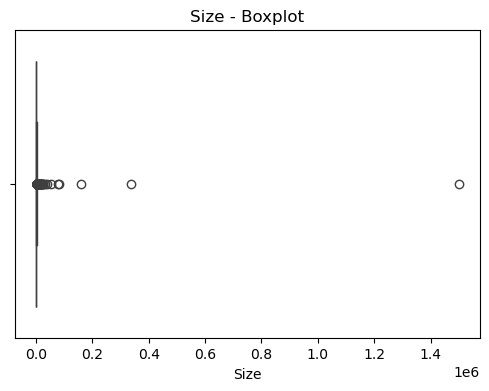

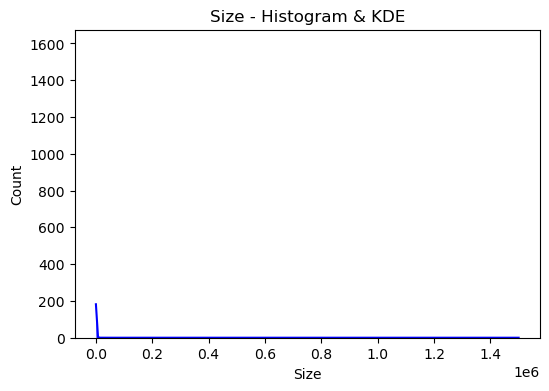

In [383]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Örnek: IQR metoduyla outlier tespiti
numeric_cols = df.select_dtypes(include=[np.number]).columns

for col in numeric_cols:
    
    # -------- Görselleştirme Kısmı --------
    
    # 1) Boxplot
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df, x=col)
    plt.title(f"{col} - Boxplot")
    plt.show()

    # 2) Histogram
    plt.figure(figsize=(6, 4))
    sns.histplot(data=df, x=col, kde=True, color='blue')
    plt.title(f"{col} - Histogram & KDE")
    plt.show()


In [384]:
df

,Address,Price,Property Type,Bedrooms,Bathrooms,Size,Posta Kodu
0,"Kingston Road, London, SW20",340000.0,Flat,1.0,1.0,388.0,SW20
1,"Witley Court, Coram Street, Bloomsbury, London...",340000.0,Apartment,NaN,1.0,230.0,WC1N
2,"Cribb Lodge, 20 Love Lane, Woolwich, London, SE18",340000.0,Apartment,2.0,1.0,NaN,SE18
3,"Hopewell Yard, Hopewell Street, London, SE5",340000.0,Flat,2.0,1.0,NaN,SE5
4,"48 Warton Road, London, E15",340000.0,Apartment,1.0,1.0,NaN,E15
...,...,...,...,...,...,...,...
28556,"Marylebone High Street, Copperfield House, W1U",1185000.0,NaN,2.0,2.0,NaN,W1U
28557,"Ellesmere Road, \nTurnham Green, W4",1185000.0,Semi-Detached,4.0,3.0,NaN,W4
28558,"Rathbone Place, London, W1T",1185000.0,Apartment,1.0,1.0,556.0,W1T
28559,"New Union Square, Nine Elms, SW11",1185000.0,Apartment,2.0,2.0,NaN,SW11


# Feature Engineering: Adding Property Type Target Column

This code block performs feature engineering by creating a new column, `Property Type Target`, based on the mean price of each property type.

### Process
1. **Calculating the Mean Price by Property Type**:
   - The `groupby()` function groups the dataset by the `Property Type` column.
   - The `Price` column's mean value is calculated for each property type.
2. **Mapping the Mean Values**:
   - The `map()` function is used to map the calculated mean prices to the corresponding property types in the `Property Type` column.
   - A new column, `Property Type Target`, is created to store these mapped mean values.
3. **Data Inspection**:
   - The `print()` function displays a subset of the DataFrame, specifically the `Property Type` and `Property Type Target` columns, for verification.
4. **Saving the Updated Dataset**:
   - The updated DataFrame is saved back into the `data.csv` file using `to_csv()`.

### Purpose
This step adds a new feature to the dataset, which can be useful for predictive modeling. The `Property Type Target` column represents the average price for each property type, providing additional context for analysis and machine learning models.


In [385]:
target_mean = df.groupby('Property Type')['Price'].mean()
df['Property Type Target'] = df['Property Type'].map(target_mean)

# Kontrol et
print(df[['Property Type', 'Property Type Target']])
df.to_csv("data.csv", index=False)

       Property Type  Property Type Target
0               Flat          8.964084e+05
1          Apartment          1.068168e+06
2          Apartment          1.068168e+06
3               Flat          8.964084e+05
4          Apartment          1.068168e+06
...              ...                   ...
28556            NaN                   NaN
28557  Semi-Detached          1.596023e+06
28558      Apartment          1.068168e+06
28559      Apartment          1.068168e+06
28560           Flat          8.964084e+05

[28561 rows x 2 columns]


# Data Preprocessing: Extracting Neighborhood and Postcode

This code block processes the `Address` column to extract two new features: `Neighborhood` (Mahalle) and `Postcode` (Posta Kodu). These extracted features are added as new columns to the dataset.

### Process
1. **Defining Extraction Functions**:
   - **`extract_mahalle(address)`**:
     - Splits the `Address` string by commas.
     - Combines all parts before the city (e.g., "London") into the `Neighborhood` value.
     - Returns the full address if no commas are present.
   - **`extract_postcode(address)`**:
     - Splits the `Address` string by commas.
     - Extracts and returns the last part as the `Postcode`.
     - Returns `None` if the address format does not match expectations.
2. **Creating New Columns**:
   - The `apply()` function is used to apply `extract_mahalle()` and `extract_postcode()` to the `Address` column.
   - The results are stored in two new columns: `Mahalle` (Neighborhood) and `Posta Kodu` (Postcode).
3. **Inspecting the Updated DataFrame**:
   - The `head()` function displays the first few rows of the updated DataFrame for verification.
4. **Saving the Updated Dataset**:
   - The DataFrame, now including the new columns, is saved back into the `data.csv` file.

### Purpose
This preprocessing step extracts and organizes address-related information into structured columns. These new features (`Neighborhood` and `Postcode`) can be valuable for location-based analysis, visualization, or model training in subsequent steps.


In [386]:
import pandas as pd
import re

# Mahalle ve Posta Kodu ayırma fonksiyonları
#Neighborhood
def extract_mahalle(address):
    # Adresi virgülle böl ve London'dan önceki kısmı birleştir
    parts = address.split(',')
    if len(parts) >= 2:
        return ','.join(parts[:-2]).strip()  # Mahalle kısmı (ilk kısımlar birleşiyor)
    return address  # Eğer virgül yoksa adresi olduğu gibi dön

"""
def extract_postcode(address):
    # Adresi virgülle böl ve son kısmı al
    parts = address.split(',')
    if len(parts) >= 3:
        return parts[-1].strip()  # Posta kodu son kısım
    return None"""

# Yeni kolonları oluştur
df["Mahalle"] = df["Address"].apply(extract_mahalle)

# Yeni tabloyu göster
print(df.head())

# Yeni CSV dosyasını kaydet
df.to_csv("data.csv", index=False)
print("Yeni dosya 'data.csv' olarak kaydedildi.")

                                             Address     Price Property Type  \
0                        Kingston Road, London, SW20  340000.0          Flat   
1  Witley Court, Coram Street, Bloomsbury, London...  340000.0     Apartment   
2  Cribb Lodge, 20 Love Lane, Woolwich, London, SE18  340000.0     Apartment   
3        Hopewell Yard, Hopewell Street, London, SE5  340000.0          Flat   
4                        48 Warton Road, London, E15  340000.0     Apartment   

   Bedrooms  Bathrooms   Size Posta Kodu  Property Type Target  \
0       1.0        1.0  388.0       SW20          8.964084e+05   
1       NaN        1.0  230.0       WC1N          1.068168e+06   
2       2.0        1.0    NaN       SE18          1.068168e+06   
3       2.0        1.0    NaN        SE5          8.964084e+05   
4       1.0        1.0    NaN        E15          1.068168e+06   

                                  Mahalle  
0                           Kingston Road  
1  Witley Court, Coram Street, Blo

# Data Quality Check: Counting Null Values

This code block performs a quality check by counting the number of `NaN` (missing) values in specific columns of the dataset.

### Process
1. **Defining Columns to Check**:
   - A list of column names is created, including:
     - `Address`
     - `Price`
     - `Property Type`
     - `Bedrooms`
     - `Bathrooms`
     - `Size`
     - `Property Type Target`
     - `Mahalle` (Neighborhood)
     - `Posta Kodu` (Postcode)
2. **Counting Missing Values**:
   - The `isnull()` function checks for `NaN` values in each column.
   - The `sum()` function calculates the total count of missing values for each column.
   - A loop iterates over the column list and prints the count of `NaN` values for each column.

### Purpose
This step helps identify data quality issues by detecting missing values in key columns. Knowing which columns contain missing values and their quantity is essential for planning data cleaning and handling processes in subsequent steps.


In [387]:
#null valueler

# Kontrol edilecek kolon isimleri
kolonlar = ["Address","Price","Property Type","Bedrooms","Bathrooms","Size","Property Type Target","Mahalle","Posta Kodu"]

# Belirli kolonlardaki NaN değerlerinin sayısını göster
for kolon in kolonlar:
    print(f"{kolon} kolonundaki NaN değerlerinin sayısı: {df[kolon].isnull().sum()}")

Address kolonundaki NaN değerlerinin sayısı: 0
Price kolonundaki NaN değerlerinin sayısı: 1
Property Type kolonundaki NaN değerlerinin sayısı: 129
Bedrooms kolonundaki NaN değerlerinin sayısı: 1116
Bathrooms kolonundaki NaN değerlerinin sayısı: 1194
Size kolonundaki NaN değerlerinin sayısı: 10107
Property Type Target kolonundaki NaN değerlerinin sayısı: 129
Mahalle kolonundaki NaN değerlerinin sayısı: 0
Posta Kodu kolonundaki NaN değerlerinin sayısı: 0


# Handling Missing Values: Identifying Rows with Missing Bedrooms or Bathrooms

This code block identifies rows where the `Bedrooms` or `Bathrooms` columns have missing (`NaN`) values and analyzes their frequency by `Property Type`.

### Process
1. **Filtering Rows with Missing Values**:
   - Rows where either the `Bedrooms` or `Bathrooms` column contains `NaN` are filtered using:
     ```python
     df['Bedrooms'].isnull() | df['Bathrooms'].isnull()
     ```
   - These filtered rows are stored in a new DataFrame, `missing_bed_bath`.
2. **Grouping by `Property Type`**:
   - The filtered DataFrame is grouped by the `Property Type` column.
   - The `value_counts()` function calculates the frequency of missing values for each property type.
3. **Displaying Results**:
   - The frequency counts of missing values per property type are printed for review.

### Purpose
This step highlights the extent of missing data in the `Bedrooms` and `Bathrooms` columns for each property type. This information is critical for deciding how to handle missing values, such as imputing values or removing rows, in subsequent data cleaning steps.


In [388]:
#Nan değerlerin doldurulması

# Bedrooms veya Bathrooms sayısı olmayan satırları filtrele
missing_bed_bath = df[df['Bedrooms'].isnull() | df['Bathrooms'].isnull()]

# Property Type'a göre gruplandır ve eksik değerlerin frekansını hesapla
missing_counts = missing_bed_bath['Property Type'].value_counts()

print("Eksik Bedrooms veya Bathrooms sayısı olan Property Type frekansları:")
print(missing_counts)

Eksik Bedrooms veya Bathrooms sayısı olan Property Type frekansları:
Property Type
Apartment                       649
Flat                            523
Studio                          433
Terraced                         68
Parking                          42
Semi-Detached                    32
Maisonette                       30
Land                             29
Garages                          28
Detached                         26
Plot                             20
Block of Apartments              20
End of Terrace                   19
House                            18
Ground Flat                      16
Retirement Property              15
Town House                       11
House of Multiple Occupation      8
Duplex                            5
House Boat                        4
Penthouse                         4
Mews                              3
Bungalow                          2
Link Detached House               2
Serviced Apartments               1
Ground Maisonette

In [389]:
# Property Type "Studio" olan satırlarda Bedrooms ve Bathrooms kolonlarını 1 yap
df.loc[(df['Property Type'] == 'Studio') & (df['Bedrooms'].isnull()), 'Bedrooms'] = 1
df.loc[(df['Property Type'] == 'Studio') & (df['Bathrooms'].isnull()), 'Bathrooms'] = 1
df.to_csv("data.csv", index=False)

# Grouping and Visualizing Property Types

This code block groups property types into broader categories, calculates their distribution, and visualizes the results using pie and bar charts.

### Process

1. **Defining the `group_property_type` Function**:
   - Groups property types into the following categories:
     - **ApartmentLike**: Includes types like "Apartment", "Flat", "Studio", etc.
     - **HouseLike**: Includes various house types such as "Detached", "Terraced", and "Bungalow".
     - **LuxuryFlats**: High-end properties like "Penthouse", "Duplex", and "Villa".
     - **Special**: Unique property types like "House Boat" and "Park Home".
     - **Other**: Any property type not explicitly listed.
   - The function is applied to the `Property Type` column to create a new column, `property_group`.

2. **Calculating Group Counts**:
   - The `value_counts()` method calculates the frequency of each property group in the `property_group` column.

3. **Visualizing with Pie Chart**:
   - A pie chart is created using `plot.pie()`:
     - **`autopct="%1.1f%%"`**: Displays percentages for each slice.
     - **`startangle=90`**: Starts the first slice vertically for better alignment.
     - **`colors=plt.cm.Paired.colors`**: Uses a predefined color palette for differentiation.
   - The chart is titled "Property Type Gruplarının Yüzdesel Dağılımı".

4. **Visualizing with Bar Chart**:
   - A bar chart is created using `plot.bar()`:
     - **`color="skyblue"`**: Uses a light blue color for the bars.
     - **`alpha=0.8`**: Adjusts transparency for better visual appeal.
     - Titles and labels:
       - Chart title: "Property Type Gruplarının Sayısal Dağılımı".
       - X-axis label: "Property Group".
       - Y-axis label: "Count".
     - X-axis ticks are rotated for readability.

5. **Displaying the Charts**:
   - Both charts are displayed using `plt.show()` after ensuring proper layout with `plt.tight_layout()`.

### Purpose
This step organizes property types into meaningful groups and visualizes their distribution to provide insights into property type composition. Pie charts highlight proportional relationships, while bar charts emphasize absolute counts, making the data easier to interpret.


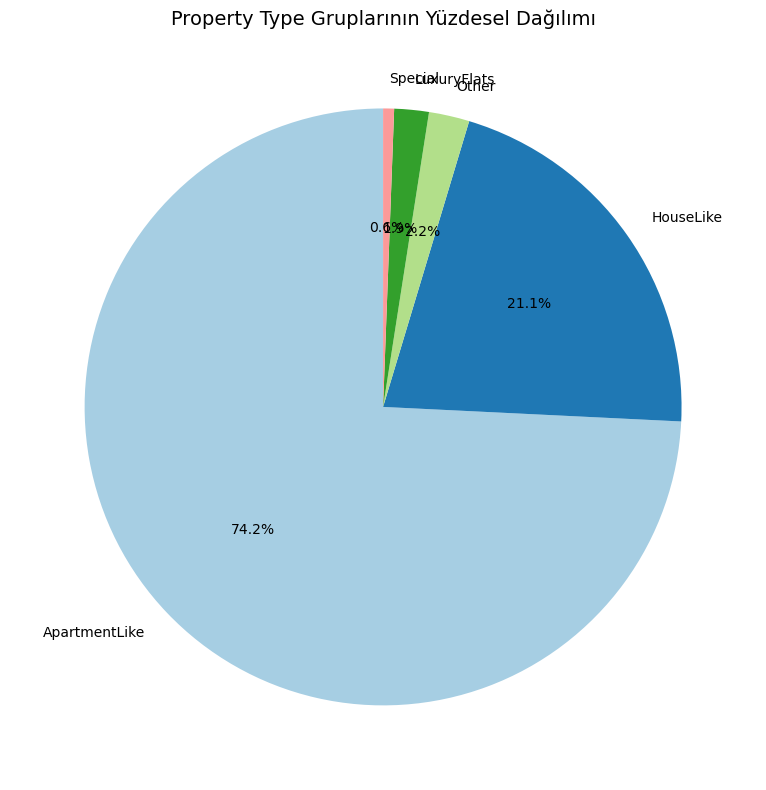

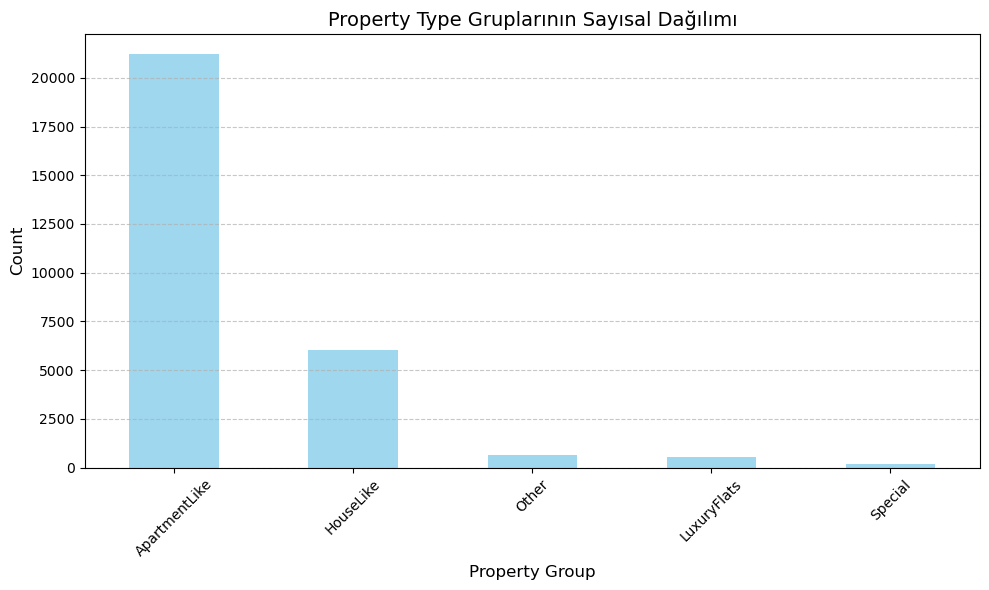

In [390]:
# ev tipini grupla 

def group_property_type(ptype):
    if ptype in ["Apartment", "Flat", "Studio", "Block of Apartments"]:
        return "ApartmentLike"
    elif ptype in ["House", "Terraced", "Semi-Detached", "Detached", "End of Terrace", 
                   "Town House", "Bungalow", "Maisonette", "Ground Maisonette"]:
        return "HouseLike"
    elif ptype in ["Duplex", "Triplex", "Penthouse", "Villa"]:
        return "LuxuryFlats"
    elif ptype in ["House Boat", "Park Home", "Retirement Property", "House of Multiple Occupation"]:
        return "Special"
    else:
        return "Other"

df["property_group"] = df["Property Type"].apply(group_property_type)

# Her grubun sayısını hesapla
group_counts = df["property_group"].value_counts()

# Pasta grafiği (Pie Chart)
plt.figure(figsize=(8, 8))
group_counts.plot.pie(
    autopct="%1.1f%%",  # Yüzdeleri göster
    startangle=90,      # İlk dilimi dikey başlat
    colors=plt.cm.Paired.colors  # Farklı renk paleti
)
plt.title("Property Type Gruplarının Yüzdesel Dağılımı", fontsize=14)
plt.ylabel("")  # Y ekseni başlığını kaldır
plt.tight_layout()
plt.show()

# Çubuk grafiği (Bar Chart)
plt.figure(figsize=(10, 6))
group_counts.plot.bar(
    color="skyblue", 
    alpha=0.8
)
plt.title("Property Type Gruplarının Sayısal Dağılımı", fontsize=14)
plt.xlabel("Property Group", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


- Save to csv file to avoid lose all we did if we did something wrong

In [391]:
df.to_csv("data.csv", index=False)

# Handling Missing Values: Preparing for KNN Imputation

This code block prepares the dataset for KNN (K-Nearest Neighbors) imputation by marking rows with missing values in the `Bedrooms` and `Bathrooms` columns.

### Process
1. **Importing the KNN Imputer**:
   - The `KNNImputer` from `sklearn` is imported for later use in filling missing values.
2. **Creating Missing Value Indicators**:
   - Two new columns are added to the dataset:
     - **`bedrooms_missing`**: Indicates whether the `Bedrooms` column has a missing (`NaN`) value (1 for missing, 0 otherwise).
     - **`bathrooms_missing`**: Indicates whether the `Bathrooms` column has a missing (`NaN`) value.
   - These indicators are created using the `isnull()` function and converted to integers using `astype(int)`.
3. **Inspecting the Updated Dataset**:
   - The first 10 rows of the updated dataset are displayed using `head(10)` for verification.

### Purpose
These steps ensure that missing values are appropriately flagged and prepared for KNN imputation. The new columns (`bedrooms_missing` and `bathrooms_missing`) can also provide valuable insights during analysis or modeling to account for missing data patterns.


In [392]:
from sklearn.impute import KNNImputer

df["bedrooms_missing"] = df["Bedrooms"].isnull().astype(int)
df["bathrooms_missing"] = df["Bathrooms"].isnull().astype(int)

df.head(10)


,Address,Price,Property Type,Bedrooms,Bathrooms,Size,Posta Kodu,Property Type Target,Mahalle,property_group,bedrooms_missing,bathrooms_missing
0,"Kingston Road, London, SW20",340000.0,Flat,1.0,1.0,388.0,SW20,8.964084e+05,Kingston Road,ApartmentLike,0,0
1,"Witley Court, Coram Street, Bloomsbury, London...",340000.0,Apartment,NaN,1.0,230.0,WC1N,1.068168e+06,"Witley Court, Coram Street, Bloomsbury",ApartmentLike,1,0
2,"Cribb Lodge, 20 Love Lane, Woolwich, London, SE18",340000.0,Apartment,2.0,1.0,NaN,SE18,1.068168e+06,"Cribb Lodge, 20 Love Lane, Woolwich",ApartmentLike,0,0
3,"Hopewell Yard, Hopewell Street, London, SE5",340000.0,Flat,2.0,1.0,NaN,SE5,8.964084e+05,"Hopewell Yard, Hopewell Street",ApartmentLike,0,0
4,"48 Warton Road, London, E15",340000.0,Apartment,1.0,1.0,NaN,E15,1.068168e+06,48 Warton Road,ApartmentLike,0,0
5,"Brockley Road, Brockley, SE4",340000.0,Apartment,1.0,1.0,NaN,SE4,1.068168e+06,Brockley Road,ApartmentLike,0,0
6,"Malvern Road, London, NW6",340000.0,Flat,2.0,1.0,NaN,NW6,8.964084e+05,Malvern Road,ApartmentLike,0,0
7,"Bramwell Way, London, E16 2GS",340000.0,Flat,1.0,1.0,NaN,E16,8.964084e+05,Bramwell Way,ApartmentLike,0,0
8,"Jefferson Plaza, Bow, London, E3",340000.0,Flat,1.0,1.0,470.0,E3,8.964084e+05,"Jefferson Plaza, Bow",ApartmentLike,0,0
9,"Wells Drive, London, NW9",340000.0,Maisonette,2.0,1.0,NaN,NW9,7.768766e+05,Wells Drive,HouseLike,0,0


# Data Splitting: Train-Test Split

This code block splits the dataset into training and testing sets to prepare for model training and evaluation.

### Process
1. **Splitting the Dataset**:
   - The `train_test_split()` function from `sklearn` is used to divide the dataset:
     - **Training Set (`train_df`)**: Contains 90% of the data.
     - **Testing Set (`test_df`)**: Contains 10% of the data.
   - The `test_size=0.1` parameter specifies the proportion of the dataset allocated to the test set.
   - The `random_state=42` parameter ensures reproducibility of the split.
2. **Displaying Row Counts**:
   - The number of rows in the training and testing sets is printed using the `len()` function.
3. **Inspecting the Training Set**:
   - The `train_df` DataFrame is displayed for verification and further analysis.

### Purpose
The train-test split is a critical step in machine learning workflows. It separates the data into:
   - A training set for building and fitting the model.
   - A testing set for evaluating the model's performance on unseen data.
This ensures that the model's performance is assessed objectively and prevents overfitting.


In [393]:
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)

print("Train satır sayısı:", len(train_df))
print("Test satır sayısı :", len(test_df))

train_df


Train satır sayısı: 25704
Test satır sayısı : 2857


,Address,Price,Property Type,Bedrooms,Bathrooms,Size,Posta Kodu,Property Type Target,Mahalle,property_group,bedrooms_missing,bathrooms_missing
1962,"Kinglake Street, Elephant and Castle, London, ...",300000.0,Flat,2.0,1.0,539.0,SE17,8.964084e+05,"Kinglake Street, Elephant and Castle",ApartmentLike,0,0
11798,Marsh Wall London E14,735000.0,Flat,1.0,1.0,NaN,E14,8.964084e+05,Marsh Wall London E14,ApartmentLike,0,0
13206,"Falcon Way, Isle Of Dogs, E14",475000.0,Apartment,2.0,1.0,618.0,E14,1.068168e+06,Falcon Way,ApartmentLike,0,0
8457,"MARMION ROAD, SW11",600000.0,Flat,1.0,1.0,NaN,SW11,8.964084e+05,,ApartmentLike,0,0
14754,"Hornsey Park Road, London, N8",515000.0,Apartment,3.0,2.0,940.0,N8,1.068168e+06,Hornsey Park Road,ApartmentLike,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
21575,"Eaton Rise, London, W5",2350000.0,Detached,6.0,3.0,3100.0,W5,3.454358e+06,Eaton Rise,HouseLike,0,0
5390,"Pembroke Lodge, 149 Leigham Court Road, London...",400000.0,Apartment,2.0,1.0,NaN,SW16,1.068168e+06,"Pembroke Lodge, 149 Leigham Court Road",ApartmentLike,0,0
860,"Lizban Street, London, SE3",350000.0,Detached,1.0,1.0,388.0,SE3,3.454358e+06,Lizban Street,HouseLike,0,0
15795,"Presidents Quay House, 72 St. Katharines Way, E1W",550000.0,Apartment,1.0,1.0,551.0,E1W,1.068168e+06,Presidents Quay House,ApartmentLike,0,0


# Handling Missing Values: KNN Imputation for Bedrooms and Bathrooms

This code block utilizes the K-Nearest Neighbors (KNN) imputation method to fill missing values in the `Bedrooms` and `Bathrooms` columns for both training and testing datasets.

### Process
1. **Defining Features for Imputation**:
   - A list of features (`knn_features`) is created to include:
     - `Bedrooms` and `Bathrooms`: The target columns with missing values.
     - `bedrooms_missing` and `bathrooms_missing`: Indicators for missing values.
     - `Price`: A supporting feature to assist the imputation process.
2. **Initializing the Imputer**:
   - The `KNNImputer` from `sklearn` is initialized with `n_neighbors=3`, meaning the imputation will consider the three nearest neighbors for filling missing values.
3. **Imputation on Training Data**:
   - The training dataset (`train_df`) is filtered to include only the columns in `knn_features`.
   - The `fit()` method is used to train the imputer on the training data.
   - The `transform()` method imputes missing values, and the result is converted back into a pandas DataFrame.
4. **Imputation on Testing Data**:
   - Similar steps are applied to the testing dataset (`test_df`) using the trained imputer.
5. **Updating DataFrames**:
   - The imputed values for `Bedrooms` and `Bathrooms` are added back to the training and testing DataFrames as new columns (`bedrooms_knn` and `bathrooms_knn`).

### Purpose
This step ensures that missing values in the `Bedrooms` and `Bathrooms` columns are filled using the KNN imputation method. This approach leverages relationships between features, resulting in more informed and accurate estimations compared to simple mean or median imputation.


In [394]:
knn_features = ["Bedrooms", "Bathrooms", 
                "bedrooms_missing", "bathrooms_missing",
                "Price","Property Type Target","Size"]

imputer = KNNImputer(n_neighbors=3)

# Sadece train_df üzerindeki knn_features kolonlarını alıyoruz
train_knn_data = train_df[knn_features]

# Fit edelim
imputer.fit(train_knn_data)

# Train setin impute edilmiş halini alalım
train_knn_filled = imputer.transform(train_knn_data)

train_knn_filled_df = pd.DataFrame(train_knn_filled, 
                                   columns=knn_features,
                                   index=train_df.index)

test_knn_data = test_df[knn_features]
test_knn_filled = imputer.transform(test_knn_data)

test_knn_filled_df = pd.DataFrame(test_knn_filled, 
                                  columns=knn_features,
                                  index=test_df.index)

train_df["bedrooms_knn"] = train_knn_filled_df["Bedrooms"]
train_df["bathrooms_knn"] = train_knn_filled_df["Bathrooms"]

test_df["bedrooms_knn"] = test_knn_filled_df["Bedrooms"]
test_df["bathrooms_knn"] = test_knn_filled_df["Bathrooms"]



# Finalizing the Dataset: Recombining Train and Test Sets

This code block recombines the training and testing datasets into a single DataFrame, restores the original index order, and saves the final version to a CSV file.

### Process
1. **Recombining Train and Test Sets**:
   - The `pd.concat()` function merges the `train_df` and `test_df` DataFrames along the row axis (`axis=0`).
   - This step consolidates the datasets after imputation and feature engineering.
2. **Restoring Original Index Order**:
   - The `sort_index()` function reorders the DataFrame by its original index to maintain consistency with the pre-split dataset.
   - This ensures that the data retains its original structure and sequence.
3. **Saving the Final Dataset**:
   - The completed DataFrame, `df_filled`, is saved to a CSV file named `data.csv` using the `to_csv()` method.

### Purpose
This step prepares the finalized dataset for further analysis, modeling, or reporting. The recombined and indexed dataset ensures integrity and consistency, providing a seamless transition to subsequent stages in the data pipeline.


In [395]:
# 1) train ve test'i tekrar birleştir
df_filled = pd.concat([train_df, test_df], axis=0)

# 2) Orijinal sıralamaya göre tekrar sırala (split öncesi index bazen karışabilir)
df_filled = df_filled.sort_index()

# 3) CSV'ye kaydet
df_filled.to_csv("data.csv", index=False)


# Handling Missing Values and Updating Property Type Target

This code block handles missing values in the `Property Type` column, assigns a default value for missing entries, recalculates the `Property Type Target`, and updates the dataset accordingly.

### Process
1. **Filling Missing `Property Type` Values**:
   - Rows with missing (`NaN`) values in the `Property Type` column are filled with the value `'Other'` using the `fillna()` method.
   - This ensures that every property has a valid classification, even if specific details are unavailable.
2. **Recalculating the `Property Type Target`**:
   - The mean `Price` for each `Property Type` is calculated using the `groupby()` and `mean()` methods.
   - The `map()` function is then used to assign these mean prices to the `Property Type Target` column for each row.
3. **Inspecting the Updated Data**:
   - A subset of the DataFrame, including the `Property Type` and `Property Type Target` columns, is printed for validation.

### Purpose
This step ensures that missing values in the `Property Type` column are addressed with a logical default value. By recalculating and updating the `Property Type Target`, the dataset maintains its consistency and provides an additional feature for further analysis and modeling.


In [396]:
# Property Type değeri olmayanların Property Type değerini 'Other' olarak belirle
df_filled['Property Type'] = df_filled['Property Type'].fillna('Other')

target_mean = df_filled.groupby('Property Type')['Price'].mean()
df_filled['Property Type Target'] = df_filled['Property Type'].map(target_mean)

# Kontrol et
print(df_filled[['Property Type', 'Property Type Target']])
df_filled.to_csv("data.csv", index=False)



       Property Type  Property Type Target
0               Flat          8.964084e+05
1          Apartment          1.068168e+06
2          Apartment          1.068168e+06
3               Flat          8.964084e+05
4          Apartment          1.068168e+06
...              ...                   ...
28556          Other          1.121187e+06
28557  Semi-Detached          1.596023e+06
28558      Apartment          1.068168e+06
28559      Apartment          1.068168e+06
28560           Flat          8.964084e+05

[28561 rows x 2 columns]


# Final Data Quality Check and Saving the Dataset

This code block performs a final quality check by counting the number of `NaN` values in specified columns and then saves the cleaned dataset to a CSV file.

### Process
1. **Defining Columns for Validation**:
   - A list of key columns is created, including:
     - `Address`
     - `Price`
     - `Property Type`
     - `bedrooms_knn`
     - `bathrooms_knn`
     - `Size`
     - `Property Type Target`
     - `Mahalle` (Neighborhood)
     - `Posta Kodu` (Postcode)
2. **Counting Missing Values**:
   - For each column in the list, the number of missing (`NaN`) values is calculated using the `isnull()` and `sum()` methods.
   - A loop iterates through the column list, printing the count of missing values for validation.
3. **Saving the Final Dataset**:
   - The fully cleaned and validated dataset is saved to a CSV file named `data.csv` using the `to_csv()` method.

### Purpose
This step ensures that the dataset is thoroughly cleaned and checked for missing values in critical columns. The final dataset is saved, ready for analysis, modeling, or reporting in subsequent stages.


In [397]:
kolonlar = ["Address","Price","Property Type","bedrooms_knn","bathrooms_knn","Size","Property Type Target","Mahalle","Posta Kodu"]

df = pd.read_csv("data.csv")
# Belirli kolonlardaki NaN değerlerinin sayısını göster
for kolon in kolonlar:
    print(f"{kolon} kolonundaki NaN değerlerinin sayısı: {df[kolon].isnull().sum()}")

# Price değeri olmayan satırları kaldır
df = df.dropna(subset=['Size'])
df.to_csv("data.csv", index=False)
df

Address kolonundaki NaN değerlerinin sayısı: 0
Price kolonundaki NaN değerlerinin sayısı: 1
Property Type kolonundaki NaN değerlerinin sayısı: 0
bedrooms_knn kolonundaki NaN değerlerinin sayısı: 0
bathrooms_knn kolonundaki NaN değerlerinin sayısı: 0
Size kolonundaki NaN değerlerinin sayısı: 10107
Property Type Target kolonundaki NaN değerlerinin sayısı: 0
Mahalle kolonundaki NaN değerlerinin sayısı: 1829
Posta Kodu kolonundaki NaN değerlerinin sayısı: 0


,Address,Price,Property Type,Bedrooms,Bathrooms,Size,Posta Kodu,Property Type Target,Mahalle,property_group,bedrooms_missing,bathrooms_missing,bedrooms_knn,bathrooms_knn
0,"Kingston Road, London, SW20",340000.0,Flat,1.0,1.0,388.0,SW20,8.964084e+05,Kingston Road,ApartmentLike,0,0,1.000000,1.0
1,"Witley Court, Coram Street, Bloomsbury, London...",340000.0,Apartment,NaN,1.0,230.0,WC1N,1.068168e+06,"Witley Court, Coram Street, Bloomsbury",ApartmentLike,1,0,1.666667,1.0
8,"Jefferson Plaza, Bow, London, E3",340000.0,Flat,1.0,1.0,470.0,E3,8.964084e+05,"Jefferson Plaza, Bow",ApartmentLike,0,0,1.000000,1.0
10,"Fairfield Road, Bow Quarter, E3",340000.0,Apartment,1.0,1.0,578.0,E3,1.068168e+06,Fairfield Road,ApartmentLike,0,0,1.000000,1.0
12,"Little Dimocks, London, SW12",340000.0,Flat,1.0,1.0,466.0,SW12,8.964084e+05,Little Dimocks,ApartmentLike,0,0,1.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28551,"Damac Tower, \nBond Way, SW8",1187000.0,Flat,2.0,1.0,950.0,SW8,8.964084e+05,Damac Tower,ApartmentLike,0,0,2.000000,1.0
28554,"Brassie Avenue, East Acton, London, W3",1185000.0,Semi-Detached,5.0,4.0,2072.0,W3,1.596023e+06,"Brassie Avenue, East Acton",HouseLike,0,0,5.000000,4.0
28555,"Ambassador Bulding, Embassy Gardens, Nine Elms...",1185000.0,Apartment,2.0,2.0,891.0,SW11,1.068168e+06,"Ambassador Bulding, Embassy Gardens",ApartmentLike,0,0,2.000000,2.0
28558,"Rathbone Place, London, W1T",1185000.0,Apartment,1.0,1.0,556.0,W1T,1.068168e+06,Rathbone Place,ApartmentLike,0,0,1.000000,1.0


# Encoding Categorical Data: Label Encoding and One Hot Encoding for Property Group

This code block applies label encoding to the `property_group` column, converting categorical values into numeric labels for further analysis or machine learning.

### Process
1. **Loading the Dataset**:
   - The cleaned and preprocessed DataFrame (`df_filled`) is loaded into `df`.
2. **Initializing Label Encoder**:
   - The `LabelEncoder` and `OneHotEncoder` from `sklearn.preprocessing` is instantiated to encode categorical values into numeric labels.
3. **Applying Label Encoding**:
   - The `fit_transform()` method is used to encode the `property_group` column.
   - A new column, `property_group_encoded`, is created to store the numeric labels corresponding to the categories in `property_group`.
4. **Saving the Updated Dataset**:
   - The updated DataFrame, including the encoded column, is saved to a CSV file named `data.csv`.
5. **Inspecting the Results**:
   - The `head()` function displays the first few rows of the updated DataFrame for validation.

### Purpose
This step converts categorical values in the `property_group` column into a numeric format suitable for machine learning models. Label encoding ensures that the model can interpret and process categorical features effectively.


In [398]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# CSV dosyasını yükle
df = pd.read_csv("data.csv")

# Label Encoder oluştur
label_encoder = LabelEncoder()

one_hot_encoder = OneHotEncoder(sparse=False)

# property_group kolonuna Label Encoding uygula
df['property_group_encoded'] = label_encoder.fit_transform(df['property_group'])
# property_group_encoded kolonunu One-Hot Encoding uygula

encoded_columns = one_hot_encoder.fit_transform(df[['property_group']])

# One Hot Encoding sonucu yeni sütun adlarını al
encoded_column_names = one_hot_encoder.get_feature_names_out(['property_group'])

# Yeni sütunları DataFrame'e ekle
df_encoded = pd.DataFrame(encoded_columns, columns=encoded_column_names)

# Orijinal DataFrame ile birleştir
df = pd.concat([df, df_encoded], axis=1)

print(df)

df.to_csv('data.csv', index=False)



                                                 Address      Price  \
0                            Kingston Road, London, SW20   340000.0   
1      Witley Court, Coram Street, Bloomsbury, London...   340000.0   
2                       Jefferson Plaza, Bow, London, E3   340000.0   
3                        Fairfield Road, Bow Quarter, E3   340000.0   
4                           Little Dimocks, London, SW12   340000.0   
...                                                  ...        ...   
18449                       Damac Tower, \nBond Way, SW8  1187000.0   
18450             Brassie Avenue, East Acton, London, W3  1185000.0   
18451  Ambassador Bulding, Embassy Gardens, Nine Elms...  1185000.0   
18452                        Rathbone Place, London, W1T  1185000.0   
18453          Westmont Club Residences, White City, W12  1185000.0   

       Property Type  Bedrooms  Bathrooms    Size Posta Kodu  \
0               Flat       1.0        1.0   388.0       SW20   
1          Apartmen

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# Calculating and Adding Average Price by Postcode

This code block calculates the average property price for each postcode and appends the result to the dataset, then saves the updated dataset to a CSV file.

### Process
1. **Calculating Average Price by Postcode**:
   - The `groupby()` function groups the dataset by the `Posta Kodu` column (postcode).
   - The `["Price"]` column is selected, and the `transform("mean")` function calculates the average price for each postcode.
   - The calculated average price is added as a new column, `Postcode_Price_Avg`, in the dataset.
   - Each row in the `Postcode_Price_Avg` column reflects the average price of properties within the corresponding postcode.
2. **Saving the Updated Dataset**:
   - The `to_csv()` method saves the updated DataFrame (`df`) to a CSV file named `data.csv`.
   - The `index=False` parameter ensures that row indices are not included in the saved file.

### Purpose
This step enriches the dataset with a new feature (`Postcode_Price_Avg`) that provides insights into property pricing trends by postcode. The updated dataset is saved for future analysis, visualization, or modeling.


In [399]:
# 2) Postcode bazında ortalama fiyatı hesapla ve her satıra ekle

# 'Posta Kodu' kolonunu boşluk veya virgülden ayır ve ilk kısmı al
df["Posta Kodu Tek"] = df["Posta Kodu"].str.split('[ ,]').str[0].str.strip()


df["Postcode_Price_Avg"] = df.groupby("Posta Kodu Tek")["Price"].transform("mean")

# 3) Yeni dosyaya kaydet
df.to_csv("data.csv", index=False)

# Regression for Filling Missing `Size` Values

This code block prepares the dataset and trains regression models to predict missing values in the `Size` column. It sets up the features, splits the data, and prepares for model training and evaluation.

### Process
1. **Importing Libraries**:
   - Key libraries such as `pandas`, `numpy`, and machine learning tools from `sklearn`, `xgboost`, and `lightgbm` are imported.
2. **Loading the Dataset**:
   - The cleaned dataset is loaded from `data.csv` into a pandas DataFrame.
3. **Defining Target and Features**:
   - The `Size` column is defined as the target variable for regression.
   - Features include:
     - `bedrooms_knn` and `bathrooms_knn`: Imputed values for bedrooms and bathrooms.
     - `bedrooms_missing` and `bathrooms_missing`: Missing value indicators.
     - `Price`: Property price.
     - `property_group_encoded`: Encoded property type group.
4. **Filtering Data**:
   - Rows with `NaN` values in the selected features or target column are temporarily removed using `dropna()`.
5. **Train-Test Split**:
   - The filtered dataset is split into training and testing sets:
     - 80% for training (`X_train` and `y_train`).
     - 20% for testing (`X_test` and `y_test`).
   - The `random_state=42` parameter ensures reproducibility.

### Purpose
This step sets up the necessary foundation for training regression models to predict the `Size` column. By defining features and splitting the data, the process ensures a robust pipeline for building and evaluating regression models.


In [400]:
#size için regresyon yapılacak
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error

# Modeller
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor

df= pd.read_csv("data.csv")

# Hedef (Target)
target = "Size"  # veya "size_filled"

# Özellikler (Features) - örnek set
features = [
    "bedrooms_knn",
    "bathrooms_knn",
    "bedrooms_missing",
    "bathrooms_missing",
    "Price",
    "property_group_encoded"
    
]

# Filtreleyelim (NaN kalan satırları şimdilik atmak)
data_filtered = df[features + [target]].dropna()

X_train, X_test, y_train, y_test = train_test_split(
    data_filtered[features], data_filtered[target], test_size=0.2, random_state=42
)


In [401]:
df

,Address,Price,Property Type,Bedrooms,Bathrooms,Size,Posta Kodu,Property Type Target,Mahalle,property_group,...,bedrooms_knn,bathrooms_knn,property_group_encoded,property_group_ApartmentLike,property_group_HouseLike,property_group_LuxuryFlats,property_group_Other,property_group_Special,Posta Kodu Tek,Postcode_Price_Avg
0,"Kingston Road, London, SW20",340000.0,Flat,1.0,1.0,388.0,SW20,8.964084e+05,Kingston Road,ApartmentLike,...,1.000000,1.0,0,1.0,0.0,0.0,0.0,0.0,SW20,1.124606e+06
1,"Witley Court, Coram Street, Bloomsbury, London...",340000.0,Apartment,NaN,1.0,230.0,WC1N,1.068168e+06,"Witley Court, Coram Street, Bloomsbury",ApartmentLike,...,1.666667,1.0,0,1.0,0.0,0.0,0.0,0.0,WC1N,1.302789e+06
2,"Jefferson Plaza, Bow, London, E3",340000.0,Flat,1.0,1.0,470.0,E3,8.964084e+05,"Jefferson Plaza, Bow",ApartmentLike,...,1.000000,1.0,0,1.0,0.0,0.0,0.0,0.0,E3,4.818881e+05
3,"Fairfield Road, Bow Quarter, E3",340000.0,Apartment,1.0,1.0,578.0,E3,1.068168e+06,Fairfield Road,ApartmentLike,...,1.000000,1.0,0,1.0,0.0,0.0,0.0,0.0,E3,4.818881e+05
4,"Little Dimocks, London, SW12",340000.0,Flat,1.0,1.0,466.0,SW12,8.964084e+05,Little Dimocks,ApartmentLike,...,1.000000,1.0,0,1.0,0.0,0.0,0.0,0.0,SW12,9.041969e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18449,"Damac Tower, \nBond Way, SW8",1187000.0,Flat,2.0,1.0,950.0,SW8,8.964084e+05,Damac Tower,ApartmentLike,...,2.000000,1.0,0,1.0,0.0,0.0,0.0,0.0,SW8,1.689299e+06
18450,"Brassie Avenue, East Acton, London, W3",1185000.0,Semi-Detached,5.0,4.0,2072.0,W3,1.596023e+06,"Brassie Avenue, East Acton",HouseLike,...,5.000000,4.0,1,0.0,1.0,0.0,0.0,0.0,W3,6.871731e+05
18451,"Ambassador Bulding, Embassy Gardens, Nine Elms...",1185000.0,Apartment,2.0,2.0,891.0,SW11,1.068168e+06,"Ambassador Bulding, Embassy Gardens",ApartmentLike,...,2.000000,2.0,0,1.0,0.0,0.0,0.0,0.0,SW11,1.148647e+06
18452,"Rathbone Place, London, W1T",1185000.0,Apartment,1.0,1.0,556.0,W1T,1.068168e+06,Rathbone Place,ApartmentLike,...,1.000000,1.0,0,1.0,0.0,0.0,0.0,0.0,W1T,1.753417e+06


# Training and Evaluating Models with Performance Comparison

This code block trains multiple regression models, evaluates their performance, and visualizes their R² scores and RMSE values using bar charts.

### Process

1. **Defining Models**:
   - A dictionary, `models`, contains the following models:
     - `LinearRegression`: A simple linear regression model.
     - `RandomForest`: A tree-based ensemble model with 100 estimators.
     - `GradientBoosting`: A gradient boosting regression model.
     - `XGBoost`: An XGBoost regression model.
     - `LightGBM`: A LightGBM regression model.

2. **Training and Evaluation**:
   - Each model is trained on the training dataset (`X_train`, `y_train`) using the `fit()` method.
   - Predictions are made on the test dataset (`X_test`) using the `predict()` method.
   - Performance metrics are calculated:
     - **R² Score**: Measures how well the model explains variance in the target variable.
     - **RMSE**: Root Mean Squared Error, quantifying prediction error.
   - Results are stored in lists (`model_names`, `r2_scores`, `rmse_scores`) for visualization.

3. **Printing Results**:
   - For each model, the R² score and RMSE are printed for review.

4. **Visualization**:
   - **R² Scores**:
     - Displayed as a bar chart using `plt.bar()` with a light blue color.
     - The y-axis represents R² values, with an optional upper limit of 1.
   - **RMSE**:
     - Displayed as a bar chart using `plt.bar()` with a salmon color.
     - The y-axis represents RMSE values.
   - Subplots are arranged side-by-side using `plt.subplot()`.

5. **Final Touches**:
   - Axis labels, titles, and rotation of x-axis ticks are added for clarity.
   - `plt.tight_layout()` ensures a clean and non-overlapping layout.

6. **Displaying the Plots**:
   - The charts are displayed using `plt.show()`.

### Purpose
This step trains and evaluates multiple regression models, comparing their R² scores and RMSE values to determine the best-performing model. The visualizations provide an intuitive understanding of model performance, aiding in model selection for further analysis or deployment.


Model: LinearRegression
 R^2 Score: 0.6851
 RMSE     : 610.97
---------------
Model: RandomForest
 R^2 Score: -7.4494
 RMSE     : 3164.70
---------------
Model: GradientBoosting
 R^2 Score: -12.7025
 RMSE     : 4030.14
---------------
Model: XGBoost
 R^2 Score: -100.8603
 RMSE     : 10988.10
---------------
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 311
[LightGBM] [Info] Number of data points in the train set: 14762, number of used features: 6
[LightGBM] [Info] Start training from score 1316.733911
Model: LightGBM
 R^2 Score: -12.5072
 RMSE     : 4001.32
---------------


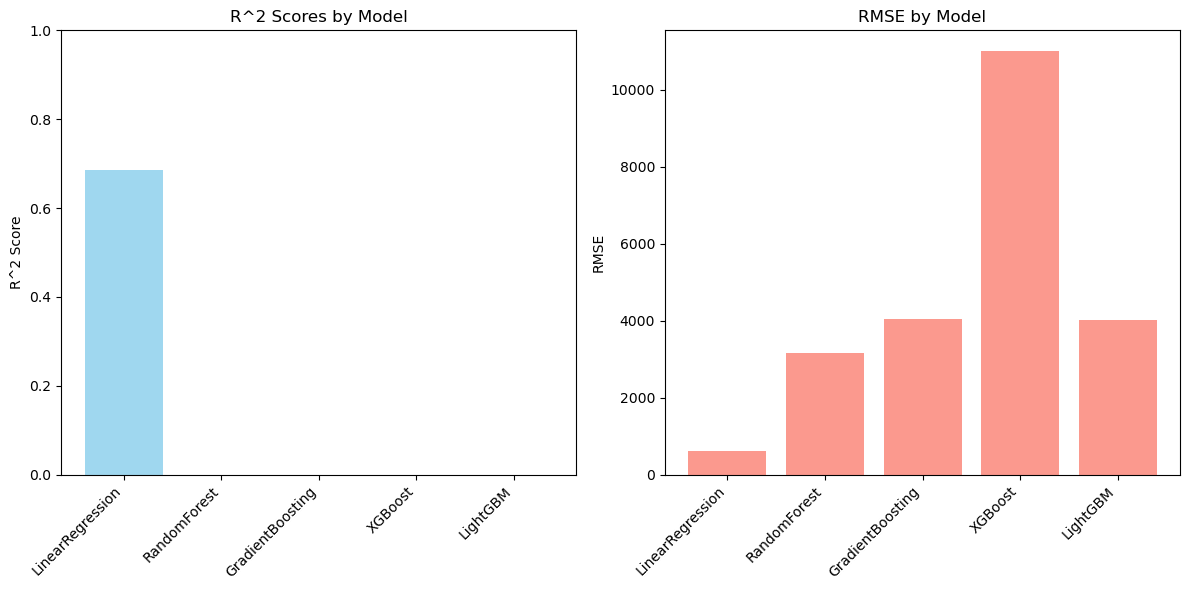

In [402]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

# Modeller
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBRegressor(n_estimators=100, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=100, random_state=42)
}

# Sonuçları saklamak için listeler
model_names = []
r2_scores = []
rmse_scores = []

# Modelleri eğit ve değerlendir
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)  # RMSE
    
    model_names.append(model_name)
    r2_scores.append(r2)
    rmse_scores.append(rmse)
    
    print(f"Model: {model_name}")
    print(f" R^2 Score: {r2:.4f}")
    print(f" RMSE     : {rmse:.2f}")
    print("---------------")

# Plot: R^2 Scores
plt.figure(figsize=(12, 6))

# İlk subplot: R^2 Scores
plt.subplot(1, 2, 1)
plt.bar(model_names, r2_scores, color='skyblue', alpha=0.8)
plt.title("R^2 Scores by Model")
plt.ylabel("R^2 Score")
plt.ylim(0, 1)  # Opsiyonel: R^2 için üst sınır
plt.xticks(rotation=45, ha='right')

# İkinci subplot: RMSE
plt.subplot(1, 2, 2)
plt.bar(model_names, rmse_scores, color='salmon', alpha=0.8)
plt.title("RMSE by Model")
plt.ylabel("RMSE")
plt.xticks(rotation=45, ha='right')

# Grafik düzenlemeleri
plt.tight_layout()
plt.show()


# Linear Regression: Training and Model Coefficients

This code block trains a linear regression model to predict the `Size` column and displays the model's coefficients and intercept.

### Process
1. **Initializing the Linear Regression Model**:
   - The `LinearRegression` class from `sklearn` is used to create the `lr_model` object.
2. **Training the Model**:
   - The `fit()` method trains the linear regression model using the training data:
     - **Features** (`X_train`)
     - **Target** (`y_train`)
3. **Displaying Model Parameters**:
   - **Coefficients (`coef_`)**:
     - The learned weights for each feature in the linear regression model.
     - These represent how much the target variable (`Size`) changes with a one-unit change in the feature.
   - **Intercept (`intercept_`)**:
     - The constant term (`b0`) in the linear regression equation.
     - Represents the value of the target variable when all features are zero.

### Purpose
This step provides insights into the linear regression model by displaying the coefficients and intercept. These parameters help explain the relationship between the features and the target variable, making the model interpretable for analysis or reporting.


In [403]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

print("Katsayılar :", lr_model.coef_)
print("Sabit (b0) :", lr_model.intercept_)

Katsayılar : [ 4.14664664e+02 -2.47210292e+01  2.31507961e+01 -5.16152663e+00
  2.79288677e-04  2.92298671e+02]
Sabit (b0) : -97.29035349265155


# Checking and Handling Missing Values in Selected Columns

This code block identifies missing values (`NaN`) in specified columns, removes rows containing these missing values, and saves the cleaned dataset to a CSV file.

### Process

1. **Defining Columns to Check**:
   - The `columns_to_check` list specifies the columns to inspect for missing values:
     - `bedrooms_knn`
     - `bathrooms_knn`
     - `Price`

2. **Displaying Dataset Size**:
   - The initial number of rows in the dataset is printed using `df.shape[0]`.

3. **Counting Missing Values**:
   - For each column in `columns_to_check`, the number of missing values is calculated using `isnull().sum()` and printed.

4. **Dropping Rows with Missing Values**:
   - Rows with missing values in any of the specified columns are removed using `dropna(subset=columns_to_check)`.
   - The cleaned dataset is stored in `df_cleaned`.

5. **Verifying Missing Values**:
   - After cleaning, the number of missing values in each column is recalculated and printed to confirm that all missing values have been removed.

6. **Displaying Updated Dataset Size**:
   - The number of rows in the cleaned dataset is printed.

7. **Saving the Cleaned Dataset**:
   - The cleaned dataset is saved to a CSV file named `data.csv` using `to_csv(index=False)`.

### Purpose
This step ensures that the dataset contains no missing values in critical columns, improving its quality and reliability for further analysis or modeling. By dropping rows with missing values, the dataset becomes more consistent and ready for downstream tasks.


In [404]:
# Kontrol edilecek kolonlar
columns_to_check = ['bedrooms_knn', 'bathrooms_knn', 'Price']

# DataFrame'in kaç satırdan oluştuğunu yazdır
num_rows = df.shape[0]
print(f"DataFrame {num_rows} satırdan oluşuyor.")

# Her kolon için NaN değer sayısını yazdır
for column in columns_to_check:
    num_missing = df[column].isnull().sum()
    print(f"{column} kolonunda NaN değer sayısı: {num_missing}")
    
# NaN değer içeren satırları dropla
df_cleaned = df.dropna(subset=columns_to_check)

# Her kolon için NaN değer sayısını yazdır
for column in columns_to_check:
    num_missing = df_cleaned[column].isnull().sum()
    print(f"{column} kolonunda NaN değer sayısı: {num_missing}")
# DataFrame'in kaç satırdan oluştuğunu yazdır
num_rows = df_cleaned.shape[0]
print(f"DataFrame {num_rows} satırdan oluşuyor.")

df_cleaned.to_csv("data.csv", index=False)

DataFrame 18454 satırdan oluşuyor.
bedrooms_knn kolonunda NaN değer sayısı: 0
bathrooms_knn kolonunda NaN değer sayısı: 0
Price kolonunda NaN değer sayısı: 1
bedrooms_knn kolonunda NaN değer sayısı: 0
bathrooms_knn kolonunda NaN değer sayısı: 0
Price kolonunda NaN değer sayısı: 0
DataFrame 18453 satırdan oluşuyor.


# Identifying Rows with Missing `Size` Values

This code block identifies and isolates rows in the dataset where the `Size` column has missing (`NaN`) values.

### Process
1. **Filtering Rows with Missing `Size` Values**:
   - The `isnull()` function is used to filter rows where the `Size` column contains `NaN` values.
   - The filtered rows are stored in a new DataFrame named `df_size_null`.
2. **Counting Missing Rows**:
   - The `len()` function calculates and prints the number of rows in `df_size_null`.

### Purpose
This step identifies rows with missing values in the `Size` column for targeted handling, such as imputation or removal. The count of missing rows provides a summary of the data quality issue in this column.


In [405]:
# size'i eksik olan satırlar
df = pd.read_csv("data.csv")
df_size_null = df[df["Size"].isnull()].copy()

print("Eksik Size satır sayısı:", len(df_size_null))


Eksik Size satır sayısı: 0


# Predicting Missing `Size` Values Using Linear Regression

This code block uses the trained linear regression model to predict missing values in the `Size` column for rows where the `Size` value is `NaN`.

### Process
1. **Selecting Features for Prediction**:
   - The same feature set used for training (`features`) is selected from `df_size_null` to create `X_predict`.
   - These features include:
     - `bedrooms_knn`, `bathrooms_knn`: Imputed values for bedrooms and bathrooms.
     - `bedrooms_missing`, `bathrooms_missing`: Indicators for missing values.
     - `Price`: Property price.
     - `property_group_encoded`: Encoded property type group.
2. **Predicting Missing `Size` Values**:
   - The `predict()` method of the trained linear regression model (`lr_model`) is used to generate predictions for the missing `Size` values in `X_predict`.
3. **Adding Predictions to DataFrame**:
   - The predicted `Size` values are added to the `df_size_null` DataFrame as a new column, `predicted_size`.
4. **Inspecting the Results**:
   - The first few rows of `df_size_null` are displayed using `head()` to verify the predictions.

### Purpose
This step predicts and fills the missing `Size` values for rows with `NaN` entries. Adding the `predicted_size` column provides a reference for these imputed values, ensuring the dataset is complete and ready for further analysis or modeling.


In [406]:
"""# Tahmin için yine aynı feature kolonlarını kullan
X_predict = df[features]

# Lineer regresyon modelinden tahmin alalım
predicted_size = lr_model.predict(X_predict)

# DataFrame'e ekleyelim
df["predicted_size"] = predicted_size
df.head()
"""


'# Tahmin için yine aynı feature kolonlarını kullan\nX_predict = df[features]\n\n# Lineer regresyon modelinden tahmin alalım\npredicted_size = lr_model.predict(X_predict)\n\n# DataFrame\'e ekleyelim\ndf["predicted_size"] = predicted_size\ndf.head()\n'

# Updating the Dataset with Predicted `Size` Values

This code block integrates the predicted `Size` values into the original dataset by creating a new column, `size_filled`, which contains both original and imputed values.

### Process
1. **Creating a `size_filled` Column**:
   - A new column, `size_filled`, is added to the original DataFrame (`df`).
   - It is initialized with the existing values in the `Size` column.
2. **Filling Missing Values**:
   - For rows with missing `Size` values, identified by their indices in `df_size_null`, the `predicted_size` values are inserted into the `size_filled` column using the `loc[]` method.
3. **Inspecting the Updated DataFrame**:
   - The first 10 rows of the updated DataFrame are displayed using `head(10)` to verify the changes.
4. **Saving the Updated Dataset**:
   - The updated DataFrame, now with the `size_filled` column, is saved to a CSV file named `data.csv` using the `to_csv()` method.

### Purpose
This step finalizes the imputation process for the `Size` column by combining original and predicted values into a single column (`size_filled`). The resulting dataset is complete and ready for subsequent analysis or modeling.


In [407]:
"""# 5.1) Orijinal DataFrame'e bir size_filled kolonu ekle
df["size_filled"] = df["Size"]

# 5.2) Eksik olan satırların index'lerine predicted_size değerlerini yerleştir
df.loc[df.index, "size_filled"] = df["predicted_size"]

# Kontrol edelim
df.head(10)

df.to_csv("data.csv", index=False)
"""

'# 5.1) Orijinal DataFrame\'e bir size_filled kolonu ekle\ndf["size_filled"] = df["Size"]\n\n# 5.2) Eksik olan satırların index\'lerine predicted_size değerlerini yerleştir\ndf.loc[df.index, "size_filled"] = df["predicted_size"]\n\n# Kontrol edelim\ndf.head(10)\n\ndf.to_csv("data.csv", index=False)\n'

In [408]:
"""# adress verisinin işlenmesi
# postakodu üstünden londra merkeze uzaklığın hesaplanması 

#kaç tane posta kodu eksik
import pandas as pd
df=pd.read_csv("data.csv")

missing_postcodes = df[df['Posta Kodu'].isnull()]
# Address kolonunu virgüle göre ayır ve son elemanı al

missing_postcodes['last_part_of_address'] = missing_postcodes['Address'].str.split(',')

# Son elemanı bastır
print(missing_postcodes['last_part_of_address'])"""

'# adress verisinin işlenmesi\n# postakodu üstünden londra merkeze uzaklığın hesaplanması \n\n#kaç tane posta kodu eksik\nimport pandas as pd\ndf=pd.read_csv("data.csv")\n\nmissing_postcodes = df[df[\'Posta Kodu\'].isnull()]\n# Address kolonunu virgüle göre ayır ve son elemanı al\n\nmissing_postcodes[\'last_part_of_address\'] = missing_postcodes[\'Address\'].str.split(\',\')\n\n# Son elemanı bastır\nprint(missing_postcodes[\'last_part_of_address\'])'

# Enhancing the Dataset with Average Coordinates by Postcode Class

This code block processes a dataset of UK postcodes, calculates average latitude and longitude for postcode classes, and merges the aggregated data back into the original dataset.

### Process
1. **Loading the Dataset**:
   - The dataset is loaded from `ukpostcodes.csv` into a pandas DataFrame (`df`).
2. **Creating the `class` Column**:
   - The `postcode` column is split by spaces, and the first part (e.g., `W12` from `W12 9AD`) is extracted into a new column named `class`.
3. **Calculating Average Latitude and Longitude**:
   - The dataset is grouped by the `class` column using `groupby()`.
   - Mean latitude (`latitude`) and longitude (`longitude`) values are calculated for each `class`.
   - The results are stored in a new DataFrame, `df_grouped`, with columns `lat_mean` and `lon_mean`.
4. **Merging Aggregated Data**:
   - The aggregated DataFrame (`df_grouped`) is merged back into the original DataFrame (`df`) using the `class` column as the key.
   - The `how="left"` merge ensures that all rows in the original DataFrame are retained, with matching `lat_mean` and `lon_mean` values added.
5. **Inspecting the Updated DataFrame**:
   - The resulting merged DataFrame (`df_merged`) contains:
     - Original latitude and longitude columns.
     - The `class` column (first part of the postcode).
     - Average latitude (`lat_mean`) and longitude (`lon_mean`) for each `class`.

### Purpose
This step enhances the dataset by adding average geographic coordinates for each postcode class. These aggregated values can be used for spatial analysis, clustering, or as additional features in predictive models.


In [412]:
df_main = df
postcodes = pd.read_csv("ukpostcodes.csv")
# 2) postcode kolonu boşlukla split: ilk kelime -> 'class' kolonu
#    Örneğin "W12 9AD" -> "W12"
postcodes["Posta Kodu Tek"] = postcodes["postcode"].str.split().str[0]

# 3) 'class' bazında lat & lon ortalamalarını hesapla
postcodes_grouped = (
    postcodes.groupby("Posta Kodu Tek", as_index=False)
      .agg({
          "latitude": "mean",
          "longitude": "mean"
      })
      .rename(columns={"lat": "lat_mean", "lon": "lon_mean"})
)

# 4) Bu ortalama değerleri orijinal tabloya eklemek için 'class' üstünden merge
df_merged = pd.merge(
    df_main,
    postcodes_grouped,  # lat_mean & lon_mean içeren tablo
    how="left",
    on="Posta Kodu Tek"
)

postcodes_grouped.to_csv("ukpostcodes_1.csv", index=False)

df_merged.to_csv("data.csv", index=False)


# Encoding Property Types Using Label Encoding

This code block applies label encoding to the `Property Type` column in the final dataset, converting categorical values into numeric labels for further analysis or machine learning.

### Process
1. **Initializing Label Encoder**:
   - An instance of `LabelEncoder` from `sklearn.preprocessing` is created.
2. **Applying Label Encoding**:
   - The `fit_transform()` method is used to encode the `Property Type` column.
   - The resulting numeric labels are stored in a new column, `Property Type Encoded`, in the `df_final` DataFrame.
3. **Displaying Results**:
   - The `Property Type Encoded` column is printed to verify the encoded values.
4. **Saving the Updated Dataset**:
   - The updated DataFrame, now with the encoded `Property Type` column, is saved to a CSV file named `data.csv` using the `to_csv()` method.

### Purpose
This step converts categorical values in the `Property Type` column into a numeric format suitable for machine learning models. The encoded values facilitate numerical computation while preserving the information contained in the original categories.


In [413]:
from sklearn.preprocessing import LabelEncoder

# Label Encoder oluşturma
label_encoder = LabelEncoder()

df = pd.read_csv("data.csv")

# Property Type kolonuna Label Encoding uygulama
df['Property Type Encoded'] = label_encoder.fit_transform(df['Property Type'])

# Sonuçları göster
print(df['Property Type Encoded'])

df.to_csv("data.csv", index=False)

0        10
1         0
2        10
3         0
4        10
         ..
18448    10
18449    30
18450     0
18451     0
18452    10
Name: Property Type Encoded, Length: 18453, dtype: int64


# Calculating Distance to Central London Using the Haversine Formula

This code block computes the great-circle distance (in kilometers) between each property in the dataset and the center of London using the Haversine formula.

### Process
1. **Defining the Haversine Function**:
   - The `haversine()` function calculates the great-circle distance between two geographic points:
     - Inputs: Latitude and longitude of two points (`lat1`, `lon1` and `lat2`, `lon2`).
     - Formula:
       - `R = 6371` (Earth's radius in kilometers).
       - Intermediate calculations involve trigonometric functions (`sin`, `cos`, and `arctan2`).
     - Output: Distance in kilometers.
2. **Defining London's Center Coordinates**:
   - Central London's approximate coordinates are defined as:
     - Latitude: `51.509865`
     - Longitude: `-0.118092`
3. **Calculating Distances**:
   - The `apply()` function applies the `haversine()` function to each row in the `df_final` DataFrame.
   - Inputs to the function are the latitude and longitude of the property (`row["latitude"]`, `row["longitude"]`) and London's center coordinates.
   - The resulting distances are stored in a new column, `dis_to_center`.
4. **Inspecting the Results**:
   - The `dis_to_center` column, which contains the distances, is printed for verification.

### Purpose
This step adds a new feature (`dis_to_center`) to the dataset, representing the distance of each property to Central London. This feature can be used in analysis, pricing models, or clustering tasks based on proximity to the city center.


In [414]:
import numpy as np

def haversine(lat1, lon1, lat2, lon2):
    """
    İki coğrafi nokta (lat1, lon1) ve (lat2, lon2) arasındaki büyük dairesel mesafeyi (km cinsinden) hesaplar.
    """
    R = 6371  # Dünya yarıçapı (kilometre)
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)

    a = np.sin(delta_phi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return R * c


# Londra merkez koordinatları
latitude_center = 51.509865
longitude_center = -0.118092

# Haversine fonksiyonu ile mesafeyi hesapla
df["dis_to_center"] = df.apply(
    lambda row: haversine(row["latitude"], row["longitude"], latitude_center, longitude_center),
    axis=1
)

# Sonuç
print(df["dis_to_center"])

0        13.368763
1         1.456867
2         6.749401
3         6.749401
4         7.382898
           ...    
18448     3.806468
18449    10.358130
18450     5.533769
18451     1.732821
18452     8.446921
Name: dis_to_center, Length: 18453, dtype: float64


In [415]:
df.to_csv("data.csv", index=False)


# Combining Crime Outcome Files for Crime Probability Analysis

This code block identifies, combines, and consolidates multiple crime outcome files containing "city-of-london" data into a single CSV file for further analysis.

### Process
1. **Defining the Base Directory**:
   - The `base_dir` variable specifies the root folder containing subdirectories with the crime outcome files.
2. **Finding Subfolders**:
   - The `os.listdir()` and `os.path.isdir()` functions identify all subdirectories within `base_dir`.
   - Subfolders are sorted and stored in the `subfolders` list.
3. **Searching for Matching Files**:
   - For each subfolder, the script searches for files with names containing `"city-of-london-outcomes"` and ending with `.csv`:
     - The `glob.glob()` function searches for files matching the pattern `*-city-of-london-outcomes.csv`.
     - Matching file paths are added to the `matching_files` list.
4. **Combining Files**:
   - If no matching files are found, a message is printed, and the process ends.
   - If matches are found:
     - Each file is read into a pandas DataFrame using `pd.read_csv()`.
     - The DataFrames are concatenated into a single DataFrame, `combined_df`, using `pd.concat()`.
5. **Saving the Combined File**:
   - The final combined DataFrame is saved as a single CSV file named `city-of-london-outcomes-ALL.csv` using `to_csv()`.
   - A success message is printed to indicate completion.

### Purpose
This step aggregates crime outcome data from multiple files into a unified dataset for analysis. The consolidated file can be used to calculate crime probabilities or derive insights based on geographic or temporal trends in crime data.


In [416]:
# crime possibilitesi hesaplama

import pandas as pd
import os
import glob

base_dir = "d10c432496a58ce4a54c62e075a0f5da64f4f756"  # Ana klasör adı

# 1) Alt klasörleri bul
subfolders = sorted([
    d for d in os.listdir(base_dir) 
    if os.path.isdir(os.path.join(base_dir, d))
])

# 2) Tarih ve "city-of-london-street" içeren dosyaları ara
matching_files = []  # Eşleşen dosyaları burada saklayacağız

for folder_name in subfolders:
    folder_path = os.path.join(base_dir, folder_name)
    
    # "city-of-london-street" içeren dosya adlarını ara
    pattern = os.path.join(folder_path, "*-city-of-london-outcomes.csv")
    found_files = glob.glob(pattern)
    
    if found_files:
        matching_files.extend(found_files)  # Bulunan dosyaları ekle

# 3) Dosyaları birleştir
if not matching_files:
    print("Hiç 'city-of-london-outcomes' dosyası bulunamadı.")
else:
    combined_df = pd.DataFrame()  # Boş bir DataFrame oluştur
    
    for file in matching_files:
        df = pd.read_csv(file)  # Dosyayı oku
        combined_df = pd.concat([combined_df, df], ignore_index=True)  # Birleştir
    
    # 4) Tek CSV olarak kaydet
    combined_df.to_csv("city-of-london-outcomes-ALL.csv", index=False)
    print(f"Tüm dosyalar birleştirildi ve 'city-of-london-outcomes-ALL.csv' olarak kaydedildi.")




Tüm dosyalar birleştirildi ve 'city-of-london-outcomes-ALL.csv' olarak kaydedildi.


# Combining Crime Street Data Files for Analysis

This code block identifies, combines, and consolidates multiple files containing "city-of-london-street" data into a single CSV file for further analysis.

### Process
1. **Defining the Base Directory**:
   - The `base_dir` variable specifies the root directory containing subfolders with the relevant files.
2. **Identifying Subfolders**:
   - The `os.listdir()` and `os.path.isdir()` functions are used to identify subdirectories within `base_dir`.
   - Subfolders are sorted and stored in the `subfolders` list.
3. **Searching for Matching Files**:
   - For each subfolder, the script searches for files with names containing `"city-of-london-street"` and ending with `.csv`:
     - The `glob.glob()` function searches for files matching the pattern `*-city-of-london-street.csv`.
     - Any matching file paths are added to the `matching_files` list.
4. **Combining Files**:
   - If no matching files are found, a message is printed, and the process terminates.
   - If matches are found:
     - Each file is read into a pandas DataFrame using `pd.read_csv()`.
     - The DataFrames are concatenated into a single DataFrame, `combined_df`, using `pd.concat()`.
5. **Saving the Combined File**:
   - The combined DataFrame is saved as a single CSV file named `city-of-london-street-ALL.csv` using `to_csv()`.
   - A success message is printed to confirm the operation.

### Purpose
This step consolidates crime street data into a unified dataset. The resulting file can be used for spatial analysis, crime trend monitoring, or integration with other datasets for enhanced insights.


In [417]:

import pandas as pd
import os
import glob

base_dir = "d10c432496a58ce4a54c62e075a0f5da64f4f756"  # Ana klasör adı

# 1) Alt klasörleri bul
subfolders = sorted([
    d for d in os.listdir(base_dir) 
    if os.path.isdir(os.path.join(base_dir, d))
])

# 2) Tarih ve "city-of-london-street" içeren dosyaları ara
matching_files = []  # Eşleşen dosyaları burada saklayacağız

for folder_name in subfolders:
    folder_path = os.path.join(base_dir, folder_name)
    
    # "city-of-london-street" içeren dosya adlarını ara
    pattern = os.path.join(folder_path, "*-city-of-london-street.csv")
    found_files = glob.glob(pattern)
    
    if found_files:
        matching_files.extend(found_files)  # Bulunan dosyaları ekle

# 3) Dosyaları birleştir
if not matching_files:
    print("Hiç 'city-of-london-street' dosyası bulunamadı.")
else:
    combined_df = pd.DataFrame()  # Boş bir DataFrame oluştur
    
    for file in matching_files:
        df = pd.read_csv(file)  # Dosyayı oku
        combined_df = pd.concat([combined_df, df], ignore_index=True)  # Birleştir
    
    # 4) Tek CSV olarak kaydet
    combined_df.to_csv("city-of-london-street-ALL.csv", index=False)
    print(f"Tüm dosyalar birleştirildi ve 'city-of-london-street-ALL.csv' olarak kaydedildi.")




Tüm dosyalar birleştirildi ve 'city-of-london-street-ALL.csv' olarak kaydedildi.


# Combining Crime Data and Visualizing Geographic Distribution

This code block merges two datasets containing longitude and latitude information, cleans missing values, saves the cleaned data, and visualizes the geographic distribution of crimes using a scatter plot.

### Process

1. **Loading Datasets**:
   - The first dataset (`city-of-london-outcomes-ALL.csv`) is loaded, selecting only the `Longitude` and `Latitude` columns using `usecols`.
   - The second dataset (`city-of-london-street-ALL.csv`) is similarly loaded with the same columns.

2. **Merging Datasets**:
   - The `pd.concat()` function merges the two DataFrames (`df1` and `df2`) into a single DataFrame (`combined_df`), resetting the index with `ignore_index=True`.

3. **Cleaning Missing Values**:
   - Rows with missing (`NaN`) values in the `Longitude` or `Latitude` columns are removed using `dropna()`.

4. **Saving the Cleaned Data**:
   - The cleaned DataFrame (`cleaned_df`) is saved to a CSV file named `combined_crimes.csv` using `to_csv()`.

5. **Visualizing Geographic Distribution**:
   - A scatter plot is created to visualize the distribution of `Longitude` and `Latitude`:
     - **Points**:
       - Represent individual records with geographic coordinates.
       - Sized (`s=10`) and colored (`c='blue'`) for clarity.
       - Transparency is adjusted using `alpha=0.5`.
     - **Axes**:
       - X-axis: `Longitude`.
       - Y-axis: `Latitude`.
     - **Details**:
       - Title: "Longitude ve Latitude Dağılımı".
       - Gridlines with dashed style for easier interpretation.

6. **Displaying the Plot**:
   - The plot is displayed using `plt.show()` with adjustments for layout using `plt.tight_layout()`.

### Purpose
This step consolidates and cleans geographic data from multiple sources, ensuring a complete and reliable dataset. The scatter plot provides a visual representation of crime locations, facilitating spatial analysis or further exploration.


Birleştirilmiş dosya kaydedildi: combined_crimes.csv


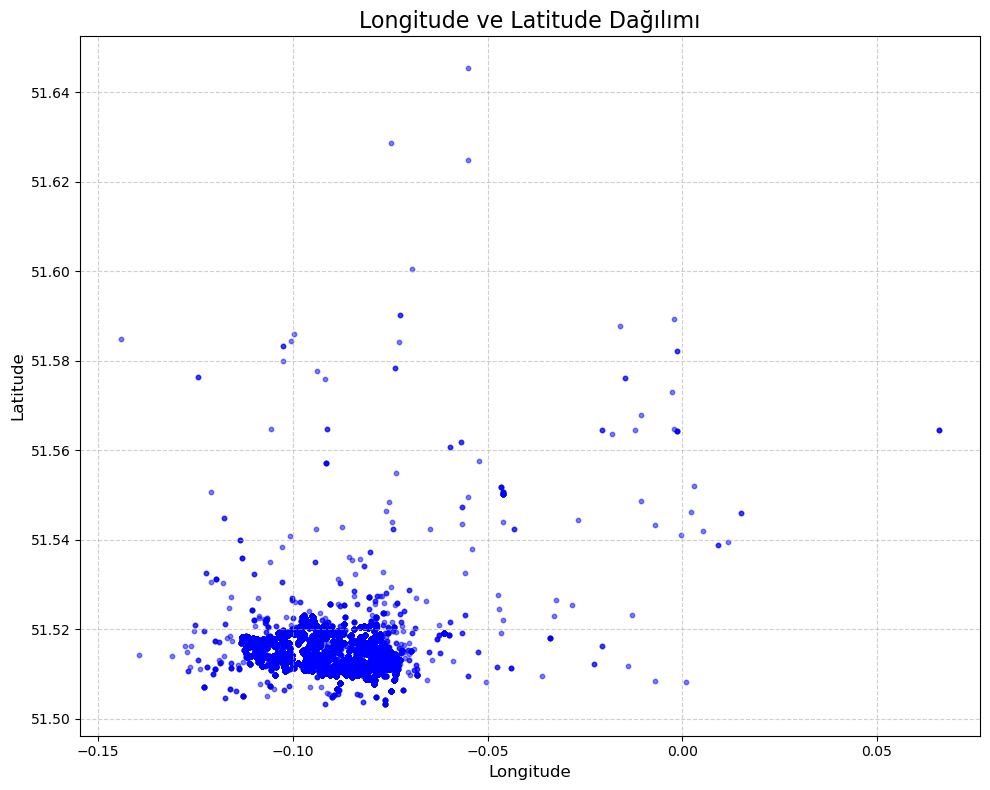

In [418]:
import pandas as pd

# 1) İlk CSV dosyasını oku ve sadece 'Longitude' ve 'Latitude' kolonlarını al
csv1_path = "city-of-london-outcomes-ALL.csv"  # İlk CSV dosyasının yolu
csv2_path = "city-of-london-street-ALL.csv"  # İkinci CSV dosyasının yolu

df1 = pd.read_csv(csv1_path, usecols=["Longitude", "Latitude"])  # Belirtilen kolonları seç
df2 = pd.read_csv(csv2_path, usecols=["Longitude", "Latitude"])  # Belirtilen kolonları seç

# 2) İki DataFrame'i birleştir (concat)
combined_df = pd.concat([df1, df2], ignore_index=True)

# 3) Eksik değerleri (boş satırları) kaldır
cleaned_df = combined_df.dropna()

# 4) Birleştirilmiş ve temizlenmiş DataFrame'i kaydet
output_path = "combined_crimes.csv"
cleaned_df.to_csv(output_path, index=False)

print(f"Birleştirilmiş dosya kaydedildi: {output_path}")

# 5) Longitude ve Latitude için scatter plot oluştur
plt.figure(figsize=(10, 8))

plt.scatter(
    cleaned_df['Longitude'], 
    cleaned_df['Latitude'], 
    alpha=0.5, 
    s=10, 
    c='blue'
)

# Grafik detayları
plt.title("Longitude ve Latitude Dağılımı", fontsize=16)
plt.xlabel("Longitude", fontsize=12)
plt.ylabel("Latitude", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Görselleştirme
plt.tight_layout()
plt.show()


In [419]:
"""import pandas as pd
from geopy.distance import geodesic

# 1) Suç verilerini ve ev verilerini yükle
df = pd.read_csv("combined_crimes.csv")  # Suç verisi (Longitude, Latitude)
houses = pd.read_csv("data.csv")  # Ev verisi (Longitude, Latitude)

# 2) 1 mil yarıçap içinde suçları hesaplamak için fonksiyon
def count_crimes_within_radius(house_row, crime_df, radius_miles=1):
    house_location = (house_row["latitude"], house_row["longitude"])  # Ev koordinatları
    crime_count = crime_df.apply(
        lambda crime_row: geodesic(house_location, (crime_row["Latitude"], crime_row["Longitude"])).miles <= radius_miles,
        axis=1
    ).sum()  # True olanları say
    return crime_count

# 3) Her ev için suç sayısını hesapla ve durum bilgisi ekle
radius_miles = 1  # 1 mil
for index, row in houses.iterrows():
    houses.loc[index, "Crime_Count"] = count_crimes_within_radius(row, df, radius_miles)
    print(f"Ev {index + 1}/{len(houses)} işlendi.")  # İşlem durumunu yazdır

# 4) Sonuçları kaydet veya göster
houses.to_csv("houses_with_crime_counts.csv", index=False)
print("Tüm evler işlendi ve sonuçlar kaydedildi.")"""


'import pandas as pd\nfrom geopy.distance import geodesic\n\n# 1) Suç verilerini ve ev verilerini yükle\ndf = pd.read_csv("combined_crimes.csv")  # Suç verisi (Longitude, Latitude)\nhouses = pd.read_csv("data.csv")  # Ev verisi (Longitude, Latitude)\n\n# 2) 1 mil yarıçap içinde suçları hesaplamak için fonksiyon\ndef count_crimes_within_radius(house_row, crime_df, radius_miles=1):\n    house_location = (house_row["latitude"], house_row["longitude"])  # Ev koordinatları\n    crime_count = crime_df.apply(\n        lambda crime_row: geodesic(house_location, (crime_row["Latitude"], crime_row["Longitude"])).miles <= radius_miles,\n        axis=1\n    ).sum()  # True olanları say\n    return crime_count\n\n# 3) Her ev için suç sayısını hesapla ve durum bilgisi ekle\nradius_miles = 1  # 1 mil\nfor index, row in houses.iterrows():\n    houses.loc[index, "Crime_Count"] = count_crimes_within_radius(row, df, radius_miles)\n    print(f"Ev {index + 1}/{len(houses)} işlendi.")  # İşlem durumunu yazdı

# Calculating Crime Counts Around Houses Using Haversine Distance

This code block calculates the number of crimes within a 1-mile radius of each house using geographic coordinates and the BallTree algorithm.

### Process
1. **Loading Datasets**:
   - The crime data is loaded from `combined_crimes.csv`.
   - The house data is loaded from `data.csv`.
2. **Converting Coordinates to Radians**:
   - Geographic coordinates (`Latitude` and `Longitude`) in both datasets are converted from degrees to radians, as required by the BallTree algorithm.
3. **Building the BallTree**:
   - A BallTree structure is created using the crime data coordinates, with the Haversine distance metric to calculate great-circle distances.
4. **Finding Crimes Within Radius**:
   - For each house, the BallTree's `query_radius()` method identifies crimes within a 1-mile radius (converted to kilometers and normalized by Earth's radius).
   - The count of crimes for each house is stored in the `crime_counts` list.
   - Progress is printed for every 100 houses processed.
5. **Adding Crime Counts to House Data**:
   - The calculated crime counts are added to the house dataset as a new column, `Crime_Count`.
6. **Saving the Results**:
   - The updated house dataset, now including `Crime_Count`, is saved back to `data.csv`.
   - A success message confirms that the process is complete.

### Purpose
This step enriches the house dataset with a crime count feature, representing the number of crimes within a 1-mile radius of each house. This feature can be used for analysis, decision-making, or as an input for predictive models.


In [420]:
import pandas as pd
from sklearn.neighbors import BallTree
import numpy as np

# 1) Suç ve ev verilerini yükle
df = pd.read_csv("combined_crimes.csv")  # Suç verisi
houses = pd.read_csv("data.csv")  # Ev verisi

houses = houses[-houses["latitude"].isnull() & -houses["longitude"].isnull()]

# 2) Koordinatları radian'a çevir (BallTree için gerekli)
df_coords = np.radians(df[["Latitude", "Longitude"]].to_numpy())
houses_coords = np.radians(houses[["latitude", "longitude"]].to_numpy())

# 3) Suç verisinden BallTree oluştur
tree = BallTree(df_coords, metric='haversine')  # Haversine mesafesi kullanıyoruz

# 4) Her ev için belirli bir yarıçaptaki suçları bul
radius_km = 1.60934  # 1 mil = 1.60934 kilometre
radius = radius_km / 6371.0  # Dünya yarıçapına göre normalize edilmiş mesafe

crime_counts = []
for i, house in enumerate(houses_coords):
    # Yarıçap içindeki suçların indekslerini bul
    indices = tree.query_radius([house], r=radius)[0]
    crime_counts.append(len(indices))  # Suç sayısını kaydet

    # İşleme durumu yazdır
    if i % 100 == 0:  # Her 100 evde bir durum yazdır
        print(f"İşleniyor: {i + 1}/{len(houses_coords)}")

# 5) Sonuçları ev verisine ekle
houses["Crime_Count"] = crime_counts

# 6) Sonuçları kaydet
houses.to_csv("data.csv", index=False)
print("İşlem tamamlandı ve sonuçlar kaydedildi.")


İşleniyor: 1/18276
İşleniyor: 101/18276
İşleniyor: 201/18276
İşleniyor: 301/18276
İşleniyor: 401/18276
İşleniyor: 501/18276
İşleniyor: 601/18276
İşleniyor: 701/18276
İşleniyor: 801/18276
İşleniyor: 901/18276
İşleniyor: 1001/18276
İşleniyor: 1101/18276
İşleniyor: 1201/18276
İşleniyor: 1301/18276
İşleniyor: 1401/18276
İşleniyor: 1501/18276
İşleniyor: 1601/18276
İşleniyor: 1701/18276
İşleniyor: 1801/18276
İşleniyor: 1901/18276
İşleniyor: 2001/18276
İşleniyor: 2101/18276
İşleniyor: 2201/18276
İşleniyor: 2301/18276
İşleniyor: 2401/18276
İşleniyor: 2501/18276
İşleniyor: 2601/18276
İşleniyor: 2701/18276
İşleniyor: 2801/18276
İşleniyor: 2901/18276
İşleniyor: 3001/18276
İşleniyor: 3101/18276
İşleniyor: 3201/18276
İşleniyor: 3301/18276
İşleniyor: 3401/18276
İşleniyor: 3501/18276
İşleniyor: 3601/18276
İşleniyor: 3701/18276
İşleniyor: 3801/18276
İşleniyor: 3901/18276
İşleniyor: 4001/18276
İşleniyor: 4101/18276
İşleniyor: 4201/18276
İşleniyor: 4301/18276
İşleniyor: 4401/18276
İşleniyor: 4501/18276


# Grouping Longitude Values and Calculating Crime Counts

This code block groups crimes by longitude ranges, calculates the number of crimes in each group, and saves the results to a CSV file.

### Process
1. **Loading the Dataset**:
   - The crime dataset is loaded from `combined_crimes.csv` into a pandas DataFrame (`df`).
2. **Defining Longitude Bins**:
   - Longitude ranges (`bins`) are defined, starting from `-0.40` and incrementing by `0.001` up to approximately `-0.15`.
   - Labels corresponding to each bin are created using the `round()` function for clarity.
3. **Grouping Longitude Values**:
   - The `pd.cut()` function assigns each longitude value in the dataset to a bin defined by `bins`.
   - A new column, `Longitude_Group`, is added to the DataFrame to store these group labels.
4. **Counting Crimes by Longitude Group**:
   - The `value_counts()` function calculates the number of crimes in each longitude group.
   - The counts are sorted by longitude groups using `sort_index()` for readability.
5. **Converting Results to a DataFrame**:
   - The counts are converted to a new DataFrame (`longitude_counts_df`) with two columns:
     - `Longitude_Group`: The longitude range label.
     - `Count`: The number of crimes in that range.
6. **Saving Results to CSV**:
   - The resulting DataFrame is saved to a CSV file named `long.csv` using `to_csv()`.

### Purpose
This step aggregates crime data based on longitude ranges, allowing for spatial analysis of crime distribution. The output file, `long.csv`, can be used for visualization or statistical reporting of crime patterns.


In [421]:
import pandas as pd

# Örnek veri setini temsil etmek için CSV'yi yükleyin
# df = pd.read_csv("crime_data.csv") # Kendi dosyanız varsa bu satırı kullanabilirsiniz

df = pd.read_csv("combined_crimes.csv")


# Longitude değerlerini gruplandır (-0.01'den başlayarak -0.13'e kadar)
bins = [-0.40 + 0.001 * i for i in range(1000)]  # -0.19'dan -0.15'e kadar 40 grup
labels = [round(-0.40 + 0.001 * i, 3) for i in range(999)]  # Etiketler

# Longitude değerlerini gruplandır
df['Longitude_Group'] = pd.cut(df['Longitude'], bins=bins, labels=labels, right=False)

# Gruplara göre suç sayısını hesapla
longitude_counts = df['Longitude_Group'].value_counts().sort_index()

# Sonuçları bir DataFrame'e dönüştür
longitude_counts_df = longitude_counts.reset_index()
longitude_counts_df.columns = ['Longitude_Group', 'Count']

# Sonuçları CSV dosyasına kaydet
longitude_counts_df.to_csv("long.csv", index=False)

# Grouping Latitude Values and Calculating Crime Counts

This code block groups crimes by latitude ranges, calculates the number of crimes in each group, and saves the results to a CSV file.

### Process
1. **Loading the Dataset**:
   - The crime dataset is loaded from `combined_crimes.csv` into a pandas DataFrame (`df`).
2. **Defining Latitude Bins**:
   - Latitude bins (`bins`) are defined, starting from `51.40` and increasing by `0.01` up to approximately `51.70`.
   - Labels for each bin are generated using the `round()` function for clarity, representing the lower bound of each bin.
3. **Grouping Latitude Values**:
   - The `pd.cut()` function assigns each latitude value in the dataset to a bin defined by `bins`.
   - A new column, `Latitude_Group`, is added to the DataFrame to store these group labels.
   - The `right=False` parameter specifies that the bins are left-closed and right-open.
4. **Counting Crimes by Latitude Group**:
   - The `value_counts()` function calculates the number of crimes in each latitude group.
   - The counts are sorted by latitude groups using `sort_index()` for readability.
5. **Converting Results to a DataFrame**:
   - The counts are converted to a new DataFrame (`latitude_counts_df`) with two columns:
     - `Latitude_Group`: The latitude range label.
     - `Count`: The number of crimes in that range.
6. **Saving Results to CSV**:
   - The resulting DataFrame is saved to a CSV file named `lat.csv` using `to_csv()`.

### Purpose
This step aggregates crime data based on latitude ranges, allowing for spatial analysis of crime distribution. The output file, `lat.csv`, can be used for visualization or statistical reporting of crime patterns.


In [422]:
import pandas as pd

# Suç verilerini oku
df = pd.read_csv("combined_crimes.csv")

# 51.52'den 51.6'ya kadar (dahil) 0.01'lik artışlarla bin sınırları
bins = [51.40 + 0.01 * i for i in range(300)]  
# [51.52, 51.53, 51.54, 51.55, 51.56, 51.57, 51.58, 51.59, 51.60]

labels = [round(51.40 + 0.01 * i, 2) for i in range(299)]
# [51.52, 51.53, 51.54, 51.55, 51.56, 51.57, 51.58, 51.59]

# Latitude kolonunu belirtilen aralıklara göre kes
df['Latitude_Group'] = pd.cut(
    df['Latitude'],
    bins=bins,
    labels=labels,
    right=False  # Son sınır dahil olsun isterseniz right=True yapabilirsiniz
)

# Her bin'e düşen suç kaydı sayısını hesapla
latitude_counts = df['Latitude_Group'].value_counts().sort_index()

# DataFrame'e çevir
latitude_counts_df = latitude_counts.reset_index()
latitude_counts_df.columns = ['Latitude_Group', 'Count']

# Sonucu CSV'ye kaydet
latitude_counts_df.to_csv("lat.csv", index=False)


# Grouping Longitude Values and Calculating Crime Counts

This code block groups crimes based on longitude ranges, calculates the number of crimes in each group, and saves the results to a CSV file.

### Process

1. **Defining Longitude Bins and Labels**:
   - **`bins`**:
     - Defines the longitude ranges, starting from `-0.110` and increasing in steps of `0.001` for 50 intervals.
   - **`labels`**:
     - Defines the labels for each bin, rounding the midpoints to three decimal places for readability.

2. **Grouping Longitude Values**:
   - The `pd.cut()` function groups the `Longitude` column into the defined bins:
     - **`bins=bins`**: Specifies the bin ranges.
     - **`labels=labels`**: Assigns labels to each group.
     - **`right=False`**: Ensures the bins are left-inclusive and right-exclusive.

3. **Calculating Crime Counts**:
   - The `value_counts()` function calculates the number of crimes in each longitude group.
   - Results are sorted by longitude using `sort_index()`.

4. **Converting Results to a DataFrame**:
   - The grouped crime counts are converted into a new DataFrame (`longitude_counts_df`) with:
     - **`Longitude_Group`**: Longitude range label.
     - **`Count`**: Number of crimes in each range.

5. **Saving Results to a CSV File**:
   - The resulting DataFrame is saved as `ekstra1.csv` using `to_csv()`.

### Purpose
This step aggregates crime data by longitude ranges, allowing for spatial analysis of crime distribution. The resulting CSV file (`ekstra1.csv`) can be used for further analysis, visualization, or integration with other datasets.


In [423]:
import pandas as pd

# Örnek veri setini temsil etmek için CSV'yi yükleyin
# df = pd.read_csv("crime_data.csv") # Kendi dosyanız varsa bu satırı kullanabilirsiniz

df = pd.read_csv("combined_crimes.csv")


bins = [-0.110 + 0.001 * i for i in range(50)]  
labels = [round(-0.11 + 0.01 * i, 3) for i in range(49)]  # Etiketler

# Longitude değerlerini gruplandır
df['Longitude_Group'] = pd.cut(df['Longitude'], bins=bins, labels=labels, right=False)

# Gruplara göre suç sayısını hesapla
longitude_counts = df['Longitude_Group'].value_counts().sort_index()

# Sonuçları bir DataFrame'e dönüştür
longitude_counts_df = longitude_counts.reset_index()
longitude_counts_df.columns = ['Longitude_Group', 'Count']

# Sonuçları CSV dosyasına kaydet
longitude_counts_df.to_csv("ekstra1.csv", index=False)

# Grouping Latitude Values and Calculating Crime Counts

This code block groups crimes based on latitude ranges, calculates the number of crimes in each group, and saves the results to a CSV file.

### Process

1. **Defining Latitude Bins and Labels**:
   - **`bins`**:
     - Defines the latitude ranges, starting from `51.510` and increasing in steps of `0.001` for 100 intervals.
   - **`labels`**:
     - Defines the labels for each bin, rounding the midpoints to three decimal places for readability.

2. **Grouping Latitude Values**:
   - The `pd.cut()` function groups the `Latitude` column into the defined bins:
     - **`bins=bins`**: Specifies the bin ranges.
     - **`labels=labels`**: Assigns labels to each group.
     - **`right=False`**: Ensures the bins are left-inclusive and right-exclusive.

3. **Calculating Crime Counts**:
   - The `value_counts()` function calculates the number of crimes in each latitude group.
   - Results are sorted by latitude using `sort_index()`.

4. **Converting Results to a DataFrame**:
   - The grouped crime counts are converted into a new DataFrame (`latitude_counts_df`) with:
     - **`Latitude_Group`**: Latitude range label.
     - **`Count`**: Number of crimes in each range.

5. **Saving Results to a CSV File**:
   - The resulting DataFrame is saved as `ekstra.csv` using `to_csv()`.

### Purpose
This step aggregates crime data by latitude ranges, enabling spatial analysis of crime distribution. The resulting CSV file (`ekstra.csv`) can be used for further analysis, visualization, or integration with other datasets.


In [424]:
import pandas as pd

# Suç verilerini oku
df = pd.read_csv("combined_crimes.csv")

# 51.52'den 51.6'ya kadar (dahil) 0.01'lik artışlarla bin sınırları
bins = [51.510 + 0.001 * i for i in range(100)]  
# [51.52, 51.53, 51.54, 51.55, 51.56, 51.57, 51.58, 51.59, 51.60]

labels = [round(51.510 + 0.001 * i, 3) for i in range(99)]
# [51.52, 51.53, 51.54, 51.55, 51.56, 51.57, 51.58, 51.59]


# Latitude kolonunu belirtilen aralıklara göre kes
df['Latitude_Group'] = pd.cut(
    df['Latitude'],
    bins=bins,
    labels=labels,
    right=False  # Son sınır dahil olsun isterseniz right=True yapabilirsiniz
)

# Her bin'e düşen suç kaydı sayısını hesapla
latitude_counts = df['Latitude_Group'].value_counts().sort_index()

# DataFrame'e çevir
latitude_counts_df = latitude_counts.reset_index()
latitude_counts_df.columns = ['Latitude_Group', 'Count']

# Sonucu CSV'ye kaydet
latitude_counts_df.to_csv("ekstra.csv", index=False)   


# Calculating Crime Probabilities and Adding Extra Counts

This code block calculates crime probabilities based on latitude and longitude values, incorporating additional data from external CSV files for specific ranges. The results are saved to the dataset.

### Process

1. **Loading the Main Dataset**:
   - The primary dataset is loaded from `data.csv`.

2. **Loading Latitude and Longitude Data**:
   - Latitude group data (`lat.csv`) and longitude group data (`long.csv`) are loaded.
   - These files contain crime counts grouped by `Latitude_Group` and `Longitude_Group`.

3. **Calculating Latitude and Longitude Probabilities**:
   - **Latitude Probabilities**:
     - For each `latitude` value in the dataset:
       - Matches the value with the corresponding group in `latitude_df`.
       - Computes the probability using `(Count + 1) / 1000`.
       - If the latitude is not found, assigns a default probability of `1/1000`.
   - **Longitude Probabilities**:
     - Similar logic is applied for `longitude` using `longitude_df`.

4. **Loading Extra Latitude and Longitude Data**:
   - Additional data files (`ekstra.csv` and `ekstra1.csv`) are loaded for specific latitude and longitude ranges.

5. **Adding Extra Counts**:
   - **Extra Latitude Count**:
     - For latitude values starting with `51.51`:
       - Matches the value with the corresponding group in `extra_latitude_df`.
       - Retrieves the count or assigns `1/1000` if not found.
   - **Extra Longitude Count**:
     - For longitude values within specific ranges (e.g., starting with `-0.1`, `0.1`, `0.2`):
       - Matches the value with `extra_longitude_df`.
       - Retrieves the count or assigns `1/1000` if not found.

6. **Saving the Updated Dataset**:
   - The updated DataFrame is saved back to `data.csv`.

7. **Printing Completion Message**:
   - Confirms the successful creation of the updated file.

### Purpose
This step enriches the dataset with crime probabilities and additional counts based on geographic location. These features enhance spatial analysis and provide valuable input for modeling or visualization.


In [426]:


import pandas as pd

# 1) Ana CSV dosyasını oku (ilk örnekteki gibi "data.csv")
df = pd.read_csv("data.csv")

# 2) Latitude ve Longitude CSV dosyalarını oku
latitude_df = pd.read_csv("lat.csv")#Latitude_Group var 
longitude_df = pd.read_csv("long.csv")#Longitude_Group var

# 3) Latitude ve Longitude değerlerine göre Prob hesapla
#    (Değerleri .round() ederek, +1 ve toplam 44.000'e bölme mantığı)
df['Latitude_Prob'] = df['latitude'].apply(
    lambda x: (
        (latitude_df[latitude_df['Latitude_Group'].round(2) == round(x, 2)]['Count'].values[0] + 1) / 1000
    )
    if round(x, 2) in latitude_df['Latitude_Group'].round(2).values
    else 1/1000
)

df['Longitude_Prob'] = df['longitude'].apply(
    lambda x: (
        (longitude_df[longitude_df['Longitude_Group'].round(2) == round(x, 2)]['Count'].values[0] + 1) / 1000
    )
    if round(x, 2) in longitude_df['Longitude_Group'].round(2).values
    else 1/1000
)

# 4) Ekstra CSV'leri oku (51.51 ile başlayan lat & belirli aralıklarla başlayan long)
extra_latitude_df = pd.read_csv("ekstra.csv")
extra_longitude_df = pd.read_csv("ekstra1.csv")

# 4a) Latitude 51.51 ile başlıyorsa, ekstra CSV dosyasındaki Count'u bul
df['Extra_Latitude_Count'] = df['latitude'].apply(
    lambda x: extra_latitude_df[ extra_latitude_df['Latitude_Group'].round(3) == round(x, 3) ]['Count'].values[0]
    if str(round(x, 3)).startswith('51.51')
       and round(x, 3) in extra_latitude_df['Latitude_Group'].round(3).values
    else 1/1000
)

# 4b) Longitude belirli aralıklarla başlıyorsa, ekstra1.csv'den Count'u çek
df['Extra_Longitude_Count'] = df['longitude'].apply(
    lambda x: extra_longitude_df[ extra_longitude_df['Longitude_Group'].round(2) == round(x, 2) ]['Count'].values[0]
    if (
        str(round(x, 2)).startswith('-0.1') or
        str(round(x, 0)).startswith('-0.0') or
        str(round(x, 0)).startswith('0.')   or
        str(round(x, 2)).startswith('0.1')  or
        str(round(x, 2)).startswith('0.2')
    )
    and round(x, 2) in extra_longitude_df['Longitude_Group'].round(2).values
    else 1/1000
)

# 5) Sonuçları kaydet
df.to_csv("data.csv", index=False)
print("İşlem tamamlandı. 'data.csv' dosyası oluşturuldu.")


İşlem tamamlandı. 'data.csv' dosyası oluşturuldu.


In [427]:
df.columns

Index(['Address', 'Price', 'Property Type', 'Bedrooms', 'Bathrooms', 'Size',
       'Posta Kodu', 'Property Type Target', 'Mahalle', 'property_group',
       'bedrooms_missing', 'bathrooms_missing', 'bedrooms_knn',
       'bathrooms_knn', 'property_group_encoded',
       'property_group_ApartmentLike', 'property_group_HouseLike',
       'property_group_LuxuryFlats', 'property_group_Other',
       'property_group_Special', 'Posta Kodu Tek', 'Postcode_Price_Avg',
       'latitude', 'longitude', 'Property Type Encoded', 'dis_to_center',
       'Crime_Count', 'Latitude_Prob', 'Longitude_Prob',
       'Extra_Latitude_Count', 'Extra_Longitude_Count'],
      dtype='object')

# Dimensionality Reduction on Address Data Using TF-IDF and PCA

This code block processes textual address data, transforms it into numerical representations using TF-IDF, and reduces the dimensionality using PCA for visualization or analysis.

### Process
1. **Loading the Dataset**:
   - The dataset containing property addresses is loaded into the `data` DataFrame.
   - The `Address` column is extracted as the input for text processing.
2. **TF-IDF Vectorization**:
   - The `TfidfVectorizer` from `sklearn.feature_extraction.text` is used to convert textual addresses into numerical vectors.
   - Parameters:
     - `max_features=15000`: Limits the number of features to the top 500 most important terms by TF-IDF score.
   - The resulting `address_vectors` is a sparse matrix representing each address in a high-dimensional numerical space.
3. **PCA for Dimensionality Reduction**:
   - The `PCA` (Principal Component Analysis) technique from `sklearn.decomposition` reduces the dimensionality of the TF-IDF vectors.
   - Parameters:
     - `n_components=3`: Reduces the address vectors to 3 principal components, making the data more suitable for visualization or clustering.
   - The reduced dimensions are stored in a 2D array (`reduced_dimensions`).
4. **Adding PCA Results to the Dataset**:
   - The principal component values are added to the `data` DataFrame as new columns:
     - `PCA1`, `PCA2`, `PCA3`: Represent the first three principal components.
5. **Resulting Dataset**:
   - The updated dataset now includes the PCA-reduced numerical representation of address data for further analysis or visualization.

### Purpose
This step transforms textual address data into a numerical format and reduces its dimensionality for easier interpretation, visualization, or integration into predictive models.


In [428]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

# 1) CSV verisini yükle
data = df # Adreslerin olduğu CSV dosyası
addresses = data["Address"]  # "Address" kolonunu seçiyoruz

# 2) TF-IDF ile Adresleri Sayısallaştırma
vectorizer = TfidfVectorizer(max_features=15000)  # En fazla 500 özellik
address_vectors = vectorizer.fit_transform(addresses)

# 3) PCA ile Boyut Azaltma
pca = PCA(n_components=3)  # Boyutu 2'ye düşürüyoruz (vizualizasyon için uygun)
reduced_dimensions = pca.fit_transform(address_vectors.toarray())

# 4) Sonuçları DataFrame'e ekleme
data["PCA1"] = reduced_dimensions[:, 0]
data["PCA2"] = reduced_dimensions[:, 1]
data["PCA3"] = reduced_dimensions[:, 2]
data

,Address,Price,Property Type,Bedrooms,Bathrooms,Size,Posta Kodu,Property Type Target,Mahalle,property_group,...,Property Type Encoded,dis_to_center,Crime_Count,Latitude_Prob,Longitude_Prob,Extra_Latitude_Count,Extra_Longitude_Count,PCA1,PCA2,PCA3
0,"Kingston Road, London, SW20",340000.0,Flat,1.0,1.0,388.0,SW20,8.964084e+05,Kingston Road,ApartmentLike,...,10,13.368763,0,0.001,0.001,0.001,0.001,0.133510,-0.022081,-0.102118
1,"Witley Court, Coram Street, Bloomsbury, London...",340000.0,Apartment,NaN,1.0,230.0,WC1N,1.068168e+06,"Witley Court, Coram Street, Bloomsbury",ApartmentLike,...,0,1.456867,7168,1.854,0.005,0.001,0.001,-0.073355,-0.039288,0.073446
2,"Jefferson Plaza, Bow, London, E3",340000.0,Flat,1.0,1.0,470.0,E3,8.964084e+05,"Jefferson Plaza, Bow",ApartmentLike,...,10,6.749401,14,0.037,0.001,0.001,739.000,-0.025946,0.011753,-0.015210
3,"Fairfield Road, Bow Quarter, E3",340000.0,Apartment,1.0,1.0,578.0,E3,1.068168e+06,Fairfield Road,ApartmentLike,...,0,6.749401,14,0.037,0.001,0.001,739.000,0.089251,-0.012543,-0.069887
4,"Little Dimocks, London, SW12",340000.0,Flat,1.0,1.0,466.0,SW12,8.964084e+05,Little Dimocks,ApartmentLike,...,10,7.382898,0,0.001,0.001,0.001,0.001,-0.002174,-0.012140,-0.008979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18271,"Damac Tower, \nBond Way, SW8",1187000.0,Flat,2.0,1.0,950.0,SW8,8.964084e+05,Damac Tower,ApartmentLike,...,10,3.806468,0,0.001,0.001,0.001,0.001,-0.042414,0.069068,-0.012014
18272,"Brassie Avenue, East Acton, London, W3",1185000.0,Semi-Detached,5.0,4.0,2072.0,W3,1.596023e+06,"Brassie Avenue, East Acton",HouseLike,...,30,10.358130,0,39.660,0.001,4002.000,0.001,-0.003053,0.002867,-0.021991
18273,"Ambassador Bulding, Embassy Gardens, Nine Elms...",1185000.0,Apartment,2.0,2.0,891.0,SW11,1.068168e+06,"Ambassador Bulding, Embassy Gardens",ApartmentLike,...,0,5.533769,0,0.001,0.001,0.001,0.001,-0.010439,-0.030274,-0.000203
18274,"Rathbone Place, London, W1T",1185000.0,Apartment,1.0,1.0,556.0,W1T,1.068168e+06,Rathbone Place,ApartmentLike,...,0,1.732821,45,1.854,0.002,0.001,0.001,-0.047296,-0.008610,0.018065


In [429]:
data.to_csv("data.csv", index=False)

# Model Training for Property Price Prediction

This code block sets up the environment for training and evaluating various machine learning models to predict property prices based on the dataset.

### Process
1. **Importing Libraries**:
   - Libraries for data manipulation, preprocessing, and machine learning are imported, including:
     - **`pandas` and `numpy`**: For handling and manipulating datasets.
     - **`sklearn`**: For preprocessing, model training, and evaluation.
     - **`xgboost`, `catboost`, and `lightgbm`**: Popular gradient boosting frameworks.
   - Models included for training:
     - Linear models: `LinearRegression`, `Ridge`, `Lasso`, `ElasticNet`.
     - Tree-based models: `RandomForestRegressor`, `DecisionTreeRegressor`, `ExtraTreesRegressor`, `GradientBoostingRegressor`, `AdaBoostRegressor`.
     - Ensemble models: `CatBoostRegressor`, `LGBMRegressor`, `XGBRegressor`.
     - Neural network: `MLPRegressor`.
     - Others: `KNeighborsRegressor`, `SVR`.
2. **Loading the Dataset**:
   - The dataset is loaded from `data.csv` into a pandas DataFrame named `df`.
   - This dataset is expected to contain features and a target variable for model training.
3. **Preparation for Model Training**:
   - The following steps (to be implemented in subsequent code blocks) are implied:
     - Splitting the dataset into training and testing sets.
     - Scaling numerical features using `StandardScaler` where necessary.
     - Defining the target variable (`y`) and features (`X`).
     - Iterating through different models and evaluating their performance.

### Purpose
This step initializes the required libraries, models, and data for training predictive models. The goal is to build and evaluate multiple regression models to determine the best approach for predicting property prices.


In [430]:
# model eğitimi

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor


df = pd.read_csv("data.csv")

In [431]:

df

,Address,Price,Property Type,Bedrooms,Bathrooms,Size,Posta Kodu,Property Type Target,Mahalle,property_group,...,Property Type Encoded,dis_to_center,Crime_Count,Latitude_Prob,Longitude_Prob,Extra_Latitude_Count,Extra_Longitude_Count,PCA1,PCA2,PCA3
0,"Kingston Road, London, SW20",340000.0,Flat,1.0,1.0,388.0,SW20,8.964084e+05,Kingston Road,ApartmentLike,...,10,13.368763,0,0.001,0.001,0.001,0.001,0.133510,-0.022081,-0.102118
1,"Witley Court, Coram Street, Bloomsbury, London...",340000.0,Apartment,NaN,1.0,230.0,WC1N,1.068168e+06,"Witley Court, Coram Street, Bloomsbury",ApartmentLike,...,0,1.456867,7168,1.854,0.005,0.001,0.001,-0.073355,-0.039288,0.073446
2,"Jefferson Plaza, Bow, London, E3",340000.0,Flat,1.0,1.0,470.0,E3,8.964084e+05,"Jefferson Plaza, Bow",ApartmentLike,...,10,6.749401,14,0.037,0.001,0.001,739.000,-0.025946,0.011753,-0.015210
3,"Fairfield Road, Bow Quarter, E3",340000.0,Apartment,1.0,1.0,578.0,E3,1.068168e+06,Fairfield Road,ApartmentLike,...,0,6.749401,14,0.037,0.001,0.001,739.000,0.089251,-0.012543,-0.069887
4,"Little Dimocks, London, SW12",340000.0,Flat,1.0,1.0,466.0,SW12,8.964084e+05,Little Dimocks,ApartmentLike,...,10,7.382898,0,0.001,0.001,0.001,0.001,-0.002174,-0.012140,-0.008979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18271,"Damac Tower, \nBond Way, SW8",1187000.0,Flat,2.0,1.0,950.0,SW8,8.964084e+05,Damac Tower,ApartmentLike,...,10,3.806468,0,0.001,0.001,0.001,0.001,-0.042414,0.069068,-0.012014
18272,"Brassie Avenue, East Acton, London, W3",1185000.0,Semi-Detached,5.0,4.0,2072.0,W3,1.596023e+06,"Brassie Avenue, East Acton",HouseLike,...,30,10.358130,0,39.660,0.001,4002.000,0.001,-0.003053,0.002867,-0.021991
18273,"Ambassador Bulding, Embassy Gardens, Nine Elms...",1185000.0,Apartment,2.0,2.0,891.0,SW11,1.068168e+06,"Ambassador Bulding, Embassy Gardens",ApartmentLike,...,0,5.533769,0,0.001,0.001,0.001,0.001,-0.010439,-0.030274,-0.000203
18274,"Rathbone Place, London, W1T",1185000.0,Apartment,1.0,1.0,556.0,W1T,1.068168e+06,Rathbone Place,ApartmentLike,...,0,1.732821,45,1.854,0.002,0.001,0.001,-0.047296,-0.008610,0.018065


# Checking for Missing Values in Selected Features

This code block identifies and counts missing (`NaN`) values across a list of specified features in the dataset.

### Process
1. **Defining Feature Columns**:
   - A list of important features (`features`) is defined for analysis, including:
     - `PCA1`, `PCA2`, `PCA3`: Principal components from PCA analysis of address data.
     - `Postcode_Price_Avg`: Average property price by postcode.
     - `Crime_Count`: Number of crimes within a 1-mile radius of each property.
     - `Property Type Target`: Target property type feature.
     - `bedrooms_knn`, `bathrooms_knn`: Imputed bedroom and bathroom counts.
     - `property_group_encoded`: Encoded property group.
     - `Size`: Pproperty size.
     - `latitude`, `longitude`: Geographic coordinates.
     - `Property Type Encoded`: Encoded property type.
     - `dis_to_center`: Distance to the city center.
     - `Latitude_Prob`, `Longitude_Prob`: Crime probabilities based on latitude and longitude.
     - `Extra_Latitude_Count`, `Extra_Longitude_Count`: Additional crime counts for specific areas.
2. **Counting Missing Values**:
   - The `isna()` method checks for `NaN` values in the specified columns.
   - The `sum()` function calculates the total number of missing values in each feature.
3. **Displaying Results**:
   - The count of missing values for each feature is printed, providing insights into the data quality.

### Purpose
This step evaluates the completeness of the dataset by identifying features with missing values. The results can guide further imputation or cleaning processes to ensure the dataset is ready for analysis or model training.


In [432]:
features = ["property_group_ApartmentLike","property_group_HouseLike","property_group_LuxuryFlats","property_group_Other","property_group_Special","PCA1","PCA2","PCA3","Postcode_Price_Avg","Crime_Count","Property Type Target","bedrooms_knn","bathrooms_knn","property_group_encoded","Size","latitude","longitude","Property Type Encoded","dis_to_center","Latitude_Prob","Longitude_Prob","Extra_Latitude_Count","Extra_Longitude_Count"]

nan_counts = df[features].isna().sum()
print(nan_counts)

property_group_ApartmentLike    0
property_group_HouseLike        0
property_group_LuxuryFlats      0
property_group_Other            0
property_group_Special          0
PCA1                            0
PCA2                            0
PCA3                            0
Postcode_Price_Avg              0
Crime_Count                     0
Property Type Target            0
bedrooms_knn                    0
bathrooms_knn                   0
property_group_encoded          0
Size                            0
latitude                        0
longitude                       0
Property Type Encoded           0
dis_to_center                   0
Latitude_Prob                   0
Longitude_Prob                  0
Extra_Latitude_Count            0
Extra_Longitude_Count           0
dtype: int64


# Handling Missing Values in Property Group Columns

This code block identifies specific columns with missing (`NaN`) values, fills those values with `0`, and verifies that no missing values remain.

### Process

1. **Identifying Columns with Missing Values**:
   - The `columns_with_nan` list specifies columns where `NaN` values are expected:
     - `property_group_ApartmentLike`
     - `property_group_HouseLike`
     - `property_group_LuxuryFlats`
     - `property_group_Other`
     - `property_group_Special`

2. **Filling Missing Values**:
   - The `fillna(0)` method replaces all `NaN` values in the specified columns with `0`.
   - Updates are applied directly to the selected columns in the dataset.

3. **Verifying Missing Values**:
   - The `isna().sum()` method checks the number of `NaN` values remaining in each of the specified columns.
   - Results are printed to confirm that all missing values have been successfully replaced.

4. **Saving the Updated Dataset**:
   - The cleaned dataset is saved to `data.csv` using the `to_csv()` method.

### Purpose
This step ensures that missing values in critical property group columns are handled appropriately by filling them with `0`. This guarantees data completeness and consistency for analysis or modeling.


In [433]:
# NaN değer içeren kolonlar
columns_with_nan = [
    "property_group_ApartmentLike",
    "property_group_HouseLike",
    "property_group_LuxuryFlats",
    "property_group_Other",
    "property_group_Special"
]

# NaN değerleri 0 ile doldur
df[columns_with_nan] = df[columns_with_nan].fillna(0)

# NaN değerlerin doldurulduğunu kontrol et
nan_counts_after_fill = df[columns_with_nan].isna().sum()
print(nan_counts_after_fill)
df.to_csv("data.csv", index=False)

property_group_ApartmentLike    0
property_group_HouseLike        0
property_group_LuxuryFlats      0
property_group_Other            0
property_group_Special          0
dtype: int64


# Model Performance Comparison

This code block evaluates the performance of different regression models on training and test sets, calculates error metrics, and compares the results visually.

### Process

1. **Data Preparation and Transformation**:
   - The `X` variable consists of the features that the model will predict, while the `y` variable represents the target value (log-transformed prices).
   - The `np.log1p()` function is applied to the target variable to log-transform it, making the target distribution more meaningful.

2. **Splitting the Data into Training and Test Sets**:
   - The `train_test_split()` function splits the data into training (85%) and test (15%) sets.
   - The `random_state=42` parameter ensures that the data is split in the same way every time.

3. **Defining the Models**:
   - Various regression models (Random Forest, XGBoost, Extra Trees, K-Nearest Neighbors, Linear Regression, Decision Tree) are defined in the `models` dictionary.
   - Each model is trained using a specific starting point (`random_state=42`).

4. **Data Standardization**:
   - The `StandardScaler` is used to normalize the training and test data.
   - The training data is scaled with `fit_transform()`, while the test data is scaled using `transform()`.

5. **Training the Models and Making Predictions**:
   - Models are trained on the training data, and predictions are made on the test data.
   - Error metrics (`MSE`, `MAE`, and `R2`) are calculated for both the training and test sets.

6. **Calculating Error Metrics**:
   - The `mean_squared_error()`, `mean_absolute_error()`, and `r2_score()` functions are used to compute the error metrics for each model.
   - Results are stored to evaluate each model's performance.

7. **Visualizing the Results**:
   - The R2 scores for both training and test sets are visualized using a bar chart.
   - The `plt.bar()` function is used to compare the performance of each model on the test and training sets.

### Purpose
This step provides a comparison of various regression models and visualizes their performance. The error metrics obtained for each model are used to assess the accuracy and overall performance of the models.


Model: Random Forest
MAE Test: 0.19196717079164674
R2 Score Test: 0.9014730291788475
MAE Train: 0.07289878679536058
R2 Score Train: 0.9849055322283644
------------------------------
Model: XGBoost
MAE Test: 0.1930571955583164
R2 Score Test: 0.9044997569878275
MAE Train: 0.1365798619956732
R2 Score Train: 0.9542844568277141
------------------------------
Model: Extra Trees
MAE Test: 0.18991833513667095
R2 Score Test: 0.8994565167051154
MAE Train: 0.0037553028764928686
R2 Score Train: 0.9977478340487678
------------------------------
Model: K-Nearest Neighbors
MAE Test: 0.28731450224555993
R2 Score Test: 0.7886547276944024
MAE Train: 0.2324728344797014
R2 Score Train: 0.8651068236801676
------------------------------
Model: Linear Regression
MAE Test: 0.35448303238123074
R2 Score Test: 0.31252264581244027
MAE Train: 0.34135214967744354
R2 Score Train: 0.6961316866371708
------------------------------
Model: Decision Tree
MAE Test: 0.24964870645551732
R2 Score Test: 0.8163525073607849
MAE

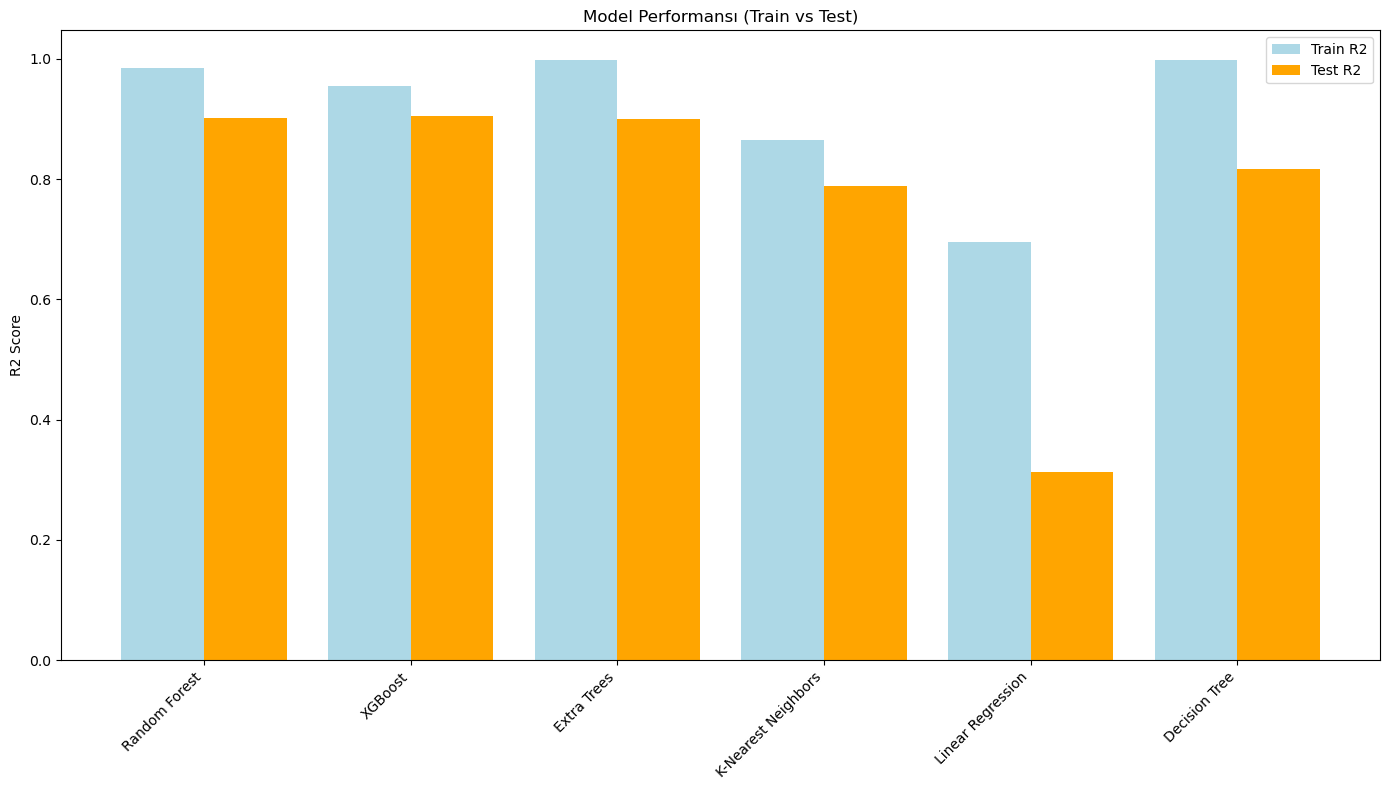

In [435]:
import matplotlib.pyplot as plt
import pandas as pd

# Hedef değişken ve özellikler
X = df[features]  # Özellikler
y = np.log1p(df["Price"])  # Hedef değişken log transform

# Veriyi train-test olarak ayır
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": xgb.XGBRegressor(random_state=42),
    "Extra Trees": ExtraTreesRegressor(random_state=42),
    "K-Nearest Neighbors": KNeighborsRegressor(),
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
}

# Performans sonuçlarını saklamak için boş bir liste
results = []

# Veriyi standardize etmek
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

for name, model in models.items():
    # Modeli eğit
    model.fit(X_train_scaled, y_train)
    
    # Test seti üzerinde tahmin yap
    y_pred_test = model.predict(X_test_scaled)
    
    # Eğitim seti üzerinde tahmin yap
    y_pred_train = model.predict(X_train_scaled)
    
    # Test seti için hata metriklerini hesapla
    mse_test = mean_squared_error(y_test, y_pred_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)
    
    # Eğitim seti için hata metriklerini hesapla
    mse_train = mean_squared_error(y_train, y_pred_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train)
    
    # Sonuçları sakla
    results.append({
        "Model": name, 
        "MSE Test": mse_test, 
        "MAE Test": mae_test, 
        "R2 Score Test": r2_test,
        "MSE Train": mse_train, 
        "MAE Train": mae_train, 
        "R2 Score Train": r2_train
    })
    
    # Hata metriklerini yazdır
    print(f"Model: {name}")
    print(f"MAE Test: {mae_test}")
    print(f"R2 Score Test: {r2_test}")
    print(f"MAE Train: {mae_train}")
    print(f"R2 Score Train: {r2_train}")
    print("-" * 30)

# Sonuçları bir DataFrame'e çevir
results_df = pd.DataFrame(results)

# Plot
plt.figure(figsize=(14, 8))

# Bar grafiği: Test ve Train R2 Scores
x = range(len(results_df["Model"]))

plt.bar([i - 0.2 for i in x], results_df["R2 Score Train"], width=0.4, label="Train R2", color="lightblue")
plt.bar([i + 0.2 for i in x], results_df["R2 Score Test"], width=0.4, label="Test R2", color="orange")

# Grafik detayları
plt.xticks(x, results_df["Model"], rotation=45, ha="right")
plt.ylabel("R2 Score")
plt.title("Model Performansı (Train vs Test)")
plt.legend()
plt.tight_layout()

# Görüntüle
plt.show()



# Results

1. **Random Forest**:
  - MAE Test: 0.19136530374074853
   - R2 Score Test: 0.9020346079397562
   - MAE Train: 0.07278509653715583
   - R2 Score Train: 0.984901479323174
2. **XGBoost**:
- MAE Test: 0.19541383525940842
- R2 Score Test: 0.903174924197522
- MAE Train: 0.13825613138076953
- R2 Score Train: 0.9530943014770009
3. **Extra Trees**:
-   MAE Test: 0.1896010543502317
-   R2 Score Test: 0.8994797109590051
-   MAE Train: 0.003755302871462963
-   R2 Score Train: 0.9977478340487678
4. **K-Nearest Neighbors**:
-   MAE Test: 0.28671422987732603
-   R2 Score Test: 0.7888962246047702
-   MAE Train: 0.2328639637838244
-   R2 Score Train: 0.8645729264986717
5. **Linear Regression**:
-   MAE Test: 0.3544480751147424
-   R2 Score Test: 0.3128801264873995
-   MAE Train: 0.3413409489746396
-   R2 Score Train: 0.6961386165023309
6. **Decision Tree**:
-   MAE Test: 0.2517272598473661
-   R2 Score Test: 0.809389861886606
-   MAE Train: 0.0037553028686280795
-   R2 Score Train: 0.9977478340487678

# Correlation Matrix and Heatmap for Features and Price

This code block calculates the correlation matrix for selected features along with the target variable (`Price`) and visualizes the correlation using a heatmap.

### Process

1. **Including `Price` in the Feature Set**:
   - The `cols_for_corr` list is created by combining the selected features (`features`) with the target variable (`Price`).
   - This ensures that the correlation between the features and the target is also included in the analysis.

2. **Calculating the Correlation Matrix**:
   - The `.corr()` function is applied to the selected columns, calculating the pairwise correlation between each feature and the target (`Price`).
   - The correlation matrix is stored in the `corr_matrix` variable.

3. **Visualizing the Correlation Matrix with a Heatmap**:
   - A heatmap is generated using `sns.heatmap()`, with annotations (`annot=True`) to display the correlation values, formatted to two decimal places (`fmt=".2f"`).
   - The `cmap="coolwarm"` parameter sets the color palette to a cool-to-warm gradient.
   - The heatmap is displayed using `plt.show()`.

### Purpose
This step visualizes the correlation between the selected features and the target variable (`Price`). By using a heatmap, it allows for easy identification of highly correlated features, helping in feature selection for further modeling.


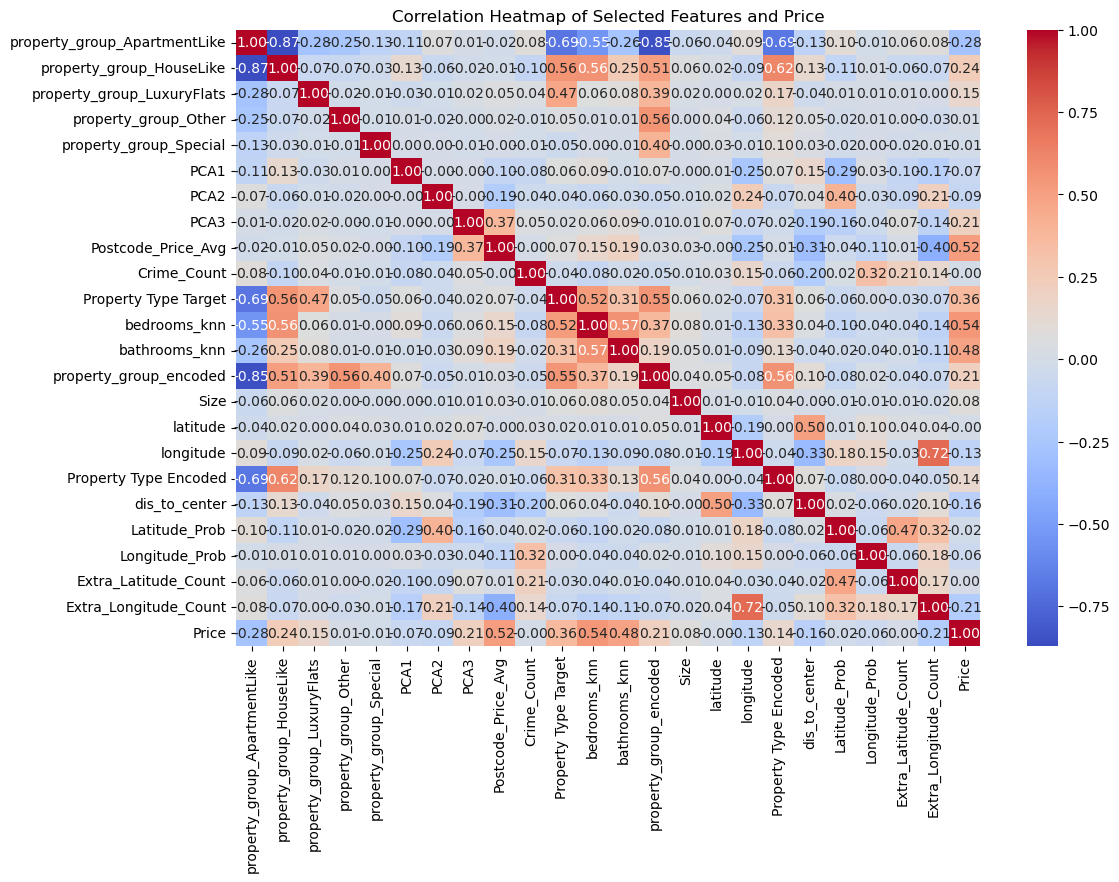

In [436]:
# Price da dahil edelim:
cols_for_corr = features + ["Price"]

# 2) Korelasyon matrisini alalım
corr_matrix = df[cols_for_corr].corr()

# 3) Isı haritası (heatmap) çizmek
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Selected Features and Price")
plt.show()

# Neural Network Model for Price Prediction

This code block creates, trains, and evaluates a neural network model to predict the target variable (`Price`). The model is built using TensorFlow/Keras and includes several hidden layers to capture complex patterns in the data.

### Process

1. **Importing Required Libraries**:
   - The necessary libraries for data manipulation (`pandas`, `numpy`), model building (`tensorflow.keras`), and evaluation (`sklearn.metrics`) are imported.

2. **Loading the Data**:
   - The dataset (`data.csv`) is loaded into a Pandas DataFrame (`df`).
   - The feature set (`X`) is defined, consisting of various engineered features related to the property.
   - The target variable (`y`) is the log-transformed `Price` column.

3. **Data Preprocessing**:
   - The data is split into training and test sets using `train_test_split()`.
   - The features (`X`) are standardized using `StandardScaler` to ensure that all features have the same scale and avoid biasing the model.

4. **Building the Neural Network Model**:
   - A Sequential model is defined with multiple Dense layers and ReLU activations. 
   - The output layer consists of a single neuron with no activation (or linear) for regression.
   - The model is compiled with the Adam optimizer and mean squared error (MSE) loss function.

5. **Training the Model**:
   - The model is trained using the training data with a batch size of 32 and up to 500 epochs.
   - Early stopping is used with a patience of 50 epochs to avoid overfitting, restoring the best weights when the validation loss stops improving.

6. **Making Predictions**:
   - After training, predictions are made on both the training and test sets.
   - The predicted values (`y_pred_train`, `y_pred_test`) are compared to the true values to evaluate model performance.

7. **Evaluating Performance**:
   - Error metrics such as Mean Squared Error (MSE), Mean Absolute Error (MAE), and R2 score are calculated for both the training and test sets to assess model performance.
   - Results are printed for both the training and test sets.

### Purpose
This code builds a neural network to predict house prices based on various features. It uses early stopping to prevent overfitting and evaluates the model's performance on both training and test data. The results provide insight into how well the model generalizes to unseen data.


In [437]:
# Gerekli kütüphaneleri import et
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf



df = pd.read_csv("data.csv")

features = ["PCA1","PCA2","PCA3","Postcode_Price_Avg","Crime_Count","Property Type Target","bedrooms_knn","bathrooms_knn","property_group_encoded","Size","latitude","longitude","Property Type Encoded","dis_to_center","Latitude_Prob","Longitude_Prob","Extra_Latitude_Count","Extra_Longitude_Count"]

X = df[features]  # Özellikler
#y = df["Price"]  # Hedef değişken

y = np.log1p(df["Price"])

# X = df.drop("target", axis=1)
# y = df["target"]

# Veriyi eğitim ve test setlerine ayır
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Veriyi ölçeklendir
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),

    Dense(1024, activation='relu'),

    Dense(128, activation='relu'),
    
    Dense(256, activation='relu'),

    Dense(64, activation='relu'),

    # Çıkış katmanı (regresyon olduğu için aktivasyon yok veya 'linear')
    Dense(1)
])

model.compile(
    loss='mean_squared_error',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['mae']  # izleme amaçlı
)

print(model.summary())

early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=50,       # 10 epoch boyunca iyileşme yoksa dur
    restore_best_weights=True
)

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=500,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


# Test veri seti üzerinde tahmin yap
y_pred = model.predict(X_test_scaled)

# Test seti üzerinde tahmin yap
y_pred_test = model.predict(X_test_scaled)
    
    # Eğitim seti üzerinde tahmin yap
y_pred_train = model.predict(X_train_scaled)

# Performans metriklerini hesapla
mse_test = mean_squared_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
    
    # Eğitim seti için hata metriklerini hesapla
mse_train = mean_squared_error(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

print(f"MSE Test: {mse_test}")
print(f"MAE Test: {mae_test}")
print(f"R2 Score Test: {r2_test}")
print(f"MSE Train: {mse_train}")
print(f"MAE Train: {mae_train}")
print(f"R2 Score Train: {r2_train}")
print("-" * 30)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 256)            │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1024)           │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 448,769 (1.71 MB)

 Trainable params: 448,769 (1.71 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/500
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 17.6184 - mae: 2.4736 - val_loss: 28.6793 - val_mae: 4.6390
Epoch 2/500
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.6734 - mae: 1.3521 - val_loss: 7.6357 - val_mae: 0.4786
Epoch 3/500
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2809 - mae: 0.3869 - val_loss: 4.0471 - val_mae: 0.4072
Epoch 4/500
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2819 - mae: 0.3576 - val_loss: 4.4762 - val_mae: 0.3701
Epoch 5/500
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2013 - mae: 0.3334 - val_loss: 3.8047 - val_mae: 0.3495
Epoch 6/500
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2175 - mae: 0.3278 - val_loss: 2.9747 - val_mae: 0.3800
Epoch 7/500
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2147 - mae: 0.3285 - val_loss: 4.2000 - val_mae: 0.3595
Epoch 8/500
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1678 - mae: 0.3110 - val_loss: 4.0838 - val_mae: 0.3803
Epoch 9/500
486/486 ━━━━━━━━━━━━━━━━━━━━ 

# Displaying Model Performance Metrics

This code block prints the calculated performance metrics for both the training and test datasets, providing insights into the model's accuracy and generalization.

### Process

1. **Metrics for the Test Set**:
   - **MSE (Mean Squared Error)**:
     - Measures the average squared difference between predicted and actual values.
     - Lower values indicate better model performance.
   - **MAE (Mean Absolute Error)**:
     - Measures the average absolute difference between predicted and actual values.
     - Lower values indicate more accurate predictions.
   - **R² Score**:
     - Represents the proportion of variance explained by the model.
     - Values closer to 1 indicate a better fit.

2. **Metrics for the Training Set**:
   - Similar metrics are calculated for the training set to evaluate how well the model fits the training data.

3. **Displaying Metrics**:
   - The `print()` function outputs:
     - Test set metrics: `MSE Test`, `MAE Test`, `R² Score Test`.
     - Training set metrics: `MSE Train`, `MAE Train`, `R² Score Train`.
   - A line of dashes (`"-" * 30`) separates the output for better readability.

### Purpose
This step provides a clear comparison of the model's performance on training and test datasets. By analyzing these metrics, you can assess whether the model is overfitting, underfitting, or generalizing well.


In [441]:
print(f"MSE Test: {mse_test}")
print(f"MAE Test: {mae_test}")
print(f"R2 Score Test: {r2_test}")
print(f"MSE Train: {mse_train}")
print(f"MAE Train: {mae_train}")
print(f"R2 Score Train: {r2_train}")
print("-" * 30)

MSE Test: 0.11326192381208983
MAE Test: 0.2166725330392031
R2 Score Test: 0.8415236593553459
MSE Train: 0.03316814985647063
MAE Train: 0.1311866578815123
R2 Score Train: 0.9558712269665064
------------------------------


# Plotting Training and Validation Loss & MAE

This code block visualizes the training and validation loss, as well as the training and validation Mean Absolute Error (MAE), over the course of the training epochs. The plots help in understanding how the model's performance evolves during training and whether overfitting or underfitting is occurring.

### Process

1. **Plotting Training and Validation Loss**:
   - The `history.history['loss']` and `history.history['val_loss']` values are plotted to show how the training loss and validation loss change over epochs.
   - The plot helps visualize if the model is improving and if there is any overfitting (when validation loss starts increasing while training loss decreases).

2. **Plotting Training and Validation MAE**:
   - The `history.history['mae']` and `history.history['val_mae']` values are plotted to show the Mean Absolute Error (MAE) for both training and validation datasets.
   - MAE gives an idea of how far off the model’s predictions are from the actual values in terms of absolute magnitude.

3. **Displaying the Plots**:
   - Both plots are displayed side by side using `plt.subplot()` to provide an overview of both loss and MAE metrics during training.
   - The `plt.legend()` method adds legends to the plots for better understanding.

### Purpose
This step provides visual feedback on the model's performance during training. By observing the loss and MAE plots, it’s possible to detect signs of overfitting or underfitting, helping to make decisions regarding model tuning or stopping early.


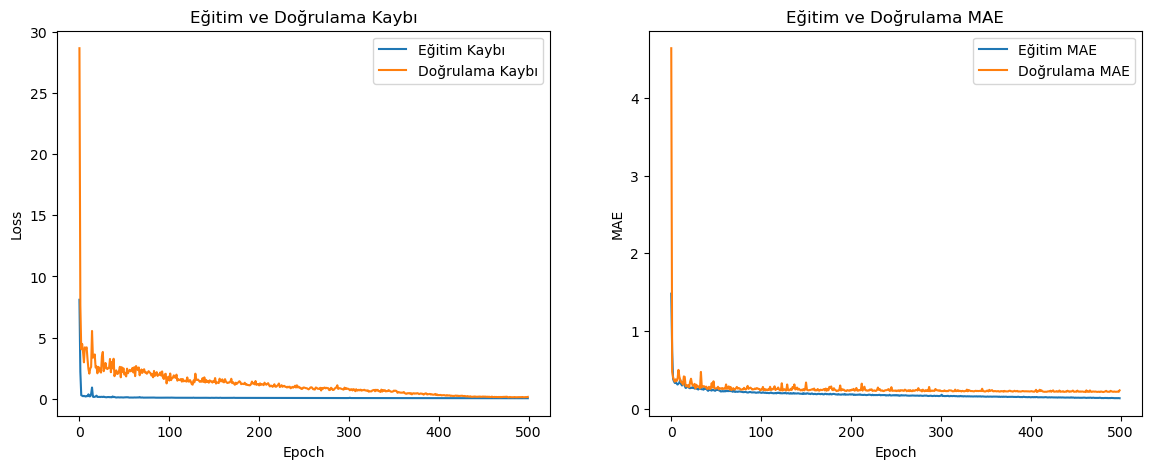

In [442]:
import matplotlib.pyplot as plt

# Eğitim ve doğrulama kayıplarını (loss) çiz
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Eğitim ve doğrulama MAE'yi çiz
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Eğitim MAE')
plt.plot(history.history['val_mae'], label='Doğrulama MAE')
plt.title('Eğitim ve Doğrulama MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.show()

# Naive Bayes Classification and Probability Analysis

This code block applies the Naive Bayes classifier to categorize property prices into different price categories and performs probability analysis on specific scenarios. It also visualizes the probabilities of events in two different scenarios using bar charts.

### Process

1. **Data Loading**:
   - **Why**: We load the dataset from `data.csv` into a Pandas DataFrame to prepare the data for analysis and model training. This allows us to perform data manipulation and feature extraction before feeding the data into the model.
   - The dataset is loaded and a list of features (`X`) is created from the DataFrame. The target variable (`y`) is derived from the price categories, which are essential for the classification task.

2. **Price Range and Category Creation**:
   - **Why**: We categorize the target variable (`Price`) into discrete price categories ("Low", "Medium", "High") using custom price bins. This is done to transform the continuous target variable into a categorical one, which is necessary for classification tasks.
   - By categorizing the price, we simplify the model's task and create more interpretable results based on property pricing.

3. **Data Splitting**:
   - **Why**: The dataset is split into training and test sets using `train_test_split()` to evaluate the model’s performance on unseen data. This ensures the model does not overfit to the training data and generalizes well to new data.
   - We use stratified sampling to maintain the proportion of classes in both training and test sets, ensuring that each class is represented equally in both sets.

4. **Data Scaling**:
   - **Why**: Scaling the features using `StandardScaler` ensures that all input features are on the same scale. Without scaling, features with larger numerical ranges could disproportionately affect the model’s performance.
   - Standardization is essential for models like Naive Bayes, where the distance between features can influence the calculations of conditional probabilities.

5. **Naive Bayes Classification**:
   - **Why**: The Naive Bayes classifier is used because it is a simple yet effective algorithm for classification problems, especially with categorical target variables. It works well with small datasets and can handle feature dependencies.
   - The model is trained on the scaled training data, and predictions are made for both training and test sets. We calculate the accuracy to measure how well the model performs.

6. **Confusion Matrix and Classification Report**:
   - **Why**: The confusion matrix and classification report are used to evaluate the model's performance. The confusion matrix shows the number of true positives, false positives, true negatives, and false negatives, which helps in understanding the model’s classification behavior.
   - The classification report provides additional evaluation metrics such as precision, recall, and F1-score, which are useful for understanding how well the model performs across each class.

7. **Scenario 1 Probability Analysis**:
   - **Why**: Probability analysis allows us to understand the relationship between two events — whether the property falls in the "High" price category and whether its size is above a threshold. This can help assess how the size of the property influences its price category.
   - We calculate the conditional probability of event A given event B (P(A|B)) and the reverse (P(B|A)), which provides insights into how likely it is to have a high-priced property given the size threshold.

8. **Scenario 2 Probability Analysis**:
   - **Why**: Similar to Scenario 1, this scenario helps us understand how properties in the "Low" price category correlate with a size below the threshold. The analysis of these relationships aids in identifying patterns between price category and property size.
   - This analysis is critical for discovering insights into property pricing dynamics and helps in making data-driven decisions for pricing or property recommendations.

9. **Visualization of Probability Values**:
   - **Why**: Visualizing the probabilities using bar charts makes it easier to interpret the results. Bar charts are intuitive and provide a clear representation of how the probabilities of the events and their conditional relationships vary across the two scenarios.
   - This visualization allows for quick insights into the likelihood of the events and helps in comparing different scenarios in a simple way.

10. **Printing the Probability Results**:
    - **Why**: The printed results provide a detailed summary of the probability values for both scenarios in a textual format. This step ensures that the user can see the precise numerical values for each metric.
    - Displaying these results in the terminal offers an easy-to-read summary that can be useful for further analysis or decision-making.

### Purpose
This step classifies properties into price categories using Naive Bayes and performs probability analysis on two different scenarios. The goal is to understand the relationships between property price categories and the size of the property. The visualizations and printed results help to interpret these relationships more clearly.

By using Naive Bayes, we benefit from a probabilistic approach that is effective for categorical outcomes. The probability analysis enhances our understanding of how different features (like property size) are related to the target variable (price category), which can be crucial for property valuation, marketing, or investment strategies.


Min Price: 25000.0, Max Price: 20000000.0

--- Naive Bayes Model ---
TRAIN Accuracy: 0.6444
TEST  Accuracy: 0.6441

--- Confusion Matrix (Test) ---
[[213 146  12]
 [163 867  74]
 [  7 574 686]]

--- Classification Report (Test) ---
              precision    recall  f1-score   support

       Düşük       0.56      0.57      0.56       371
        Orta       0.55      0.79      0.64      1104
      Yüksek       0.89      0.54      0.67      1267

    accuracy                           0.64      2742
   macro avg       0.66      0.63      0.63      2742
weighted avg       0.71      0.64      0.65      2742



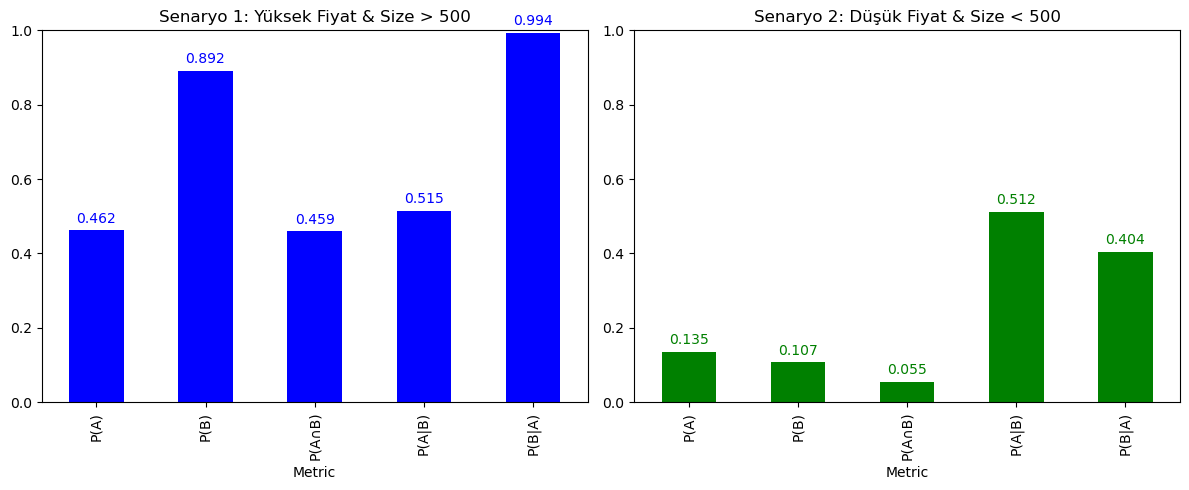


=== Wahrscheinlichkeitsanalyse - SENARYO 1 ===
Olay A: 'Evin Yüksek fiyat kategorisinde olması'
Olay B: 'Size > 500'
P(A)     = 0.462 (nA=8442)
P(B)     = 0.892 (nB=16299)
P(A ∩ B) = 0.459 (nAB=8391)
P(A|B)   = 0.515
P(B|A)   = 0.994

=== Wahrscheinlichkeitsanalyse - SENARYO 2 ===
Olay A: 'Evin Düşük fiyat kategorisinde olması'
Olay B: 'Size < 500'
P(A)     = 0.135 (nA=2473)
P(B)     = 0.107 (nB=1951)
P(A ∩ B) = 0.055 (nAB=999)
P(A|B)   = 0.512
P(B|A)   = 0.404


In [440]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

def main():
    # 1) Veriyi oku
    df = pd.read_csv("data.csv")  # CSV dosyanız

    # 2) Özellik listesi (örnek)
    features = [
        "PCA1","PCA2","PCA3","Postcode_Price_Avg","Crime_Count",
        "Property Type Target","bedrooms_knn","bathrooms_knn",
        "property_group_encoded","Size","latitude","longitude",
        "Property Type Encoded","dis_to_center","Latitude_Prob","Longitude_Prob",
        "Extra_Latitude_Count","Extra_Longitude_Count"
    ]

    X = df[features]
    price_col = "Price"

    # 3) Fiyat Aralığı
    price_min = df[price_col].min()
    price_max = df[price_col].max()
    print(f"Min Price: {price_min}, Max Price: {price_max}")

    bins = [0, 400000, 800000, np.inf]
    labels = ["Düşük", "Orta", "Yüksek"]

    df["PriceCategory"] = pd.cut(df[price_col], bins=bins, labels=labels, right=False)
    y = df["PriceCategory"]

    # 4) Train/Test bölme
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.15, random_state=42, stratify=y
    )

    # 5) (Opsiyonel) Ölçeklendirme
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 6) Naive Bayes
    model_nb = GaussianNB()
    model_nb.fit(X_train_scaled, y_train)

    y_pred_train = model_nb.predict(X_train_scaled)
    y_pred_test = model_nb.predict(X_test_scaled)

    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)

    print("\n--- Naive Bayes Model ---")
    print(f"TRAIN Accuracy: {train_acc:.4f}")
    print(f"TEST  Accuracy: {test_acc:.4f}\n")

    print("--- Confusion Matrix (Test) ---")
    print(confusion_matrix(y_test, y_pred_test))

    print("\n--- Classification Report (Test) ---")
    print(classification_report(y_test, y_pred_test))

    # ------------------------------------------------------------
    # 7) Olasılık Analizi - Senaryo 1
    # ------------------------------------------------------------
    # Olay A: "Evin Yüksek fiyat kategorisinde olması"
    # Olay B: "Size > threshold_size"
    df["OlayA_s1"] = df["PriceCategory"] == "Yüksek"
    threshold_size_s1 = 500
    df["OlayB_s1"] = df["Size"] > threshold_size_s1

    N = len(df)
    nA_s1 = len(df[df["OlayA_s1"] == True])
    P_A_s1 = nA_s1 / N

    nB_s1 = len(df[df["OlayB_s1"] == True])
    P_B_s1 = nB_s1 / N

    nAB_s1 = len(df[(df["OlayA_s1"] == True) & (df["OlayB_s1"] == True)])
    P_AB_s1 = nAB_s1 / N

    if P_B_s1 > 0:
        P_A_given_B_s1 = P_AB_s1 / P_B_s1
    else:
        P_A_given_B_s1 = 0.0

    if P_A_s1 > 0:
        P_B_given_A_s1 = P_AB_s1 / P_A_s1
    else:
        P_B_given_A_s1 = 0.0

    # Bar plot için değerleri saklayalım
    scenario1 = {
        'Metric': ["P(A)", "P(B)", "P(A∩B)", "P(A|B)", "P(B|A)"],
        'Value': [
            P_A_s1, P_B_s1, P_AB_s1, P_A_given_B_s1, P_B_given_A_s1
        ]
    }
    df_scenario1 = pd.DataFrame(scenario1)

    # ------------------------------------------------------------
    # 8) Olasılık Analizi - Senaryo 2
    # ------------------------------------------------------------
    # Olay A: "Evin Düşük fiyat kategorisinde olması"
    # Olay B: "Size < threshold_size"
    df["OlayA_s2"] = df["PriceCategory"] == "Düşük"
    threshold_size_s2 = 500
    df["OlayB_s2"] = df["Size"] < threshold_size_s2

    nA_s2 = len(df[df["OlayA_s2"] == True])
    P_A_s2 = nA_s2 / N

    nB_s2 = len(df[df["OlayB_s2"] == True])
    P_B_s2 = nB_s2 / N

    nAB_s2 = len(df[(df["OlayA_s2"] == True) & (df["OlayB_s2"] == True)])
    P_AB_s2 = nAB_s2 / N

    if P_B_s2 > 0:
        P_A_given_B_s2 = P_AB_s2 / P_B_s2
    else:
        P_A_given_B_s2 = 0.0

    if P_A_s2 > 0:
        P_B_given_A_s2 = P_AB_s2 / P_A_s2
    else:
        P_B_given_A_s2 = 0.0

    scenario2 = {
        'Metric': ["P(A)", "P(B)", "P(A∩B)", "P(A|B)", "P(B|A)"],
        'Value': [
            P_A_s2, P_B_s2, P_AB_s2, P_A_given_B_s2, P_B_given_A_s2
        ]
    }
    df_scenario2 = pd.DataFrame(scenario2)

    # ------------------------------------------------------------
    # 9) Bar Grafiklerle Olasılık Değerlerini Görselleştirme
    # ------------------------------------------------------------
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Senaryo 1 Plot
    df_scenario1.plot(
        x='Metric', 
        y='Value', 
        kind='bar', 
        color='blue', 
        ax=axes[0], 
        legend=False
    )
    axes[0].set_title("Senaryo 1: Yüksek Fiyat & Size > 500")
    axes[0].set_ylim([0,1])  # 0-1 aralığında olasılık
    for idx, val in enumerate(df_scenario1['Value']):
        axes[0].text(idx, val+0.02, f"{val:.3f}", ha='center', color='blue')

    # Senaryo 2 Plot
    df_scenario2.plot(
        x='Metric', 
        y='Value', 
        kind='bar', 
        color='green', 
        ax=axes[1], 
        legend=False
    )
    axes[1].set_title("Senaryo 2: Düşük Fiyat & Size < 500")
    axes[1].set_ylim([0,1])  # 0-1 aralığında olasılık
    for idx, val in enumerate(df_scenario2['Value']):
        axes[1].text(idx, val+0.02, f"{val:.3f}", ha='center', color='green')

    plt.tight_layout()
    plt.show()

    # ------------------------------------------------------------
    # Yazdırma (Olasılıkları terminalde de göster)
    # ------------------------------------------------------------
    print("\n=== Wahrscheinlichkeitsanalyse - SENARYO 1 ===")
    print("Olay A: 'Evin Yüksek fiyat kategorisinde olması'")
    print("Olay B: 'Size > 500'")
    print(f"P(A)     = {P_A_s1:.3f} (nA={nA_s1})")
    print(f"P(B)     = {P_B_s1:.3f} (nB={nB_s1})")
    print(f"P(A ∩ B) = {P_AB_s1:.3f} (nAB={nAB_s1})")
    print(f"P(A|B)   = {P_A_given_B_s1:.3f}")
    print(f"P(B|A)   = {P_B_given_A_s1:.3f}")

    print("\n=== Wahrscheinlichkeitsanalyse - SENARYO 2 ===")
    print("Olay A: 'Evin Düşük fiyat kategorisinde olması'")
    print("Olay B: 'Size < 500'")
    print(f"P(A)     = {P_A_s2:.3f} (nA={nA_s2})")
    print(f"P(B)     = {P_B_s2:.3f} (nB={nB_s2})")
    print(f"P(A ∩ B) = {P_AB_s2:.3f} (nAB={nAB_s2})")
    print(f"P(A|B)   = {P_A_given_B_s2:.3f}")
    print(f"P(B|A)   = {P_B_given_A_s2:.3f}")

if __name__ == "__main__":
    main()
